## Import libraries and define functions for statistical evaluation and plotting

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Avoid user warning caused by scipy

In [2]:
# Used to farmat keys of JSON files 
def format_string(input_string):
    # Replace "_" with "-"
    formatted_string = input_string.replace("_", "-")
    
    # Capitalize the first letter and each letter following "-"
    formatted_string = "".join(
        formatted_string[i].upper() if i == 0 or formatted_string[i - 1] == "-" else formatted_string[i]
        for i in range(len(formatted_string))
    )

    # Replace "-" with " "
    formatted_string = formatted_string.replace("-", " ")
    
    return formatted_string


def format_string_plot(input_string):
    
    # Capitalize the first letter and each letter following "-"
    formatted_string = "".join(
        input_string[i].upper() if i == 0 or input_string[i - 1] == "_" or input_string[i - 1] == "-" else input_string[i]
        for i in range(len(input_string))
    )
    # Replace "_" with "-"
    formatted_string = formatted_string.replace("_", " ")
    
    return formatted_string

In [3]:
def test_scores(df, metrics, type="IE"):
    
    for metric in metrics:

        print("\n" + "#" * 50)
        print(f"\n>>> Metric: {format_string(metric)}")
        
        # Pivot the DataFrame to get one row per element
        df_pivot = df.pivot(index='id', columns='label', values=metric)
    
        # Specify order of groups
        if type=="KP":
            desired_order = ["Correct", "Incorrect"]
        else:
            desired_order = ['Correct', 'Source Deviation', 'Intermediate Error', 'Final Error']
    
        # Reorder columns in the pivoted DataFrame
        df_pivot = df_pivot[desired_order]

        ### Create Plot:
        # Calculate the mean for each group
        group_means = df_pivot.mean()

        # Set scale for plot 
        SCALE = 2 # For small plot, use scale > 1

        plt.figure(figsize=(10, 6))
        
        for i, row in df_pivot.iterrows():
            plt.plot(df_pivot.columns, row, marker='o', linestyle='-', linewidth=2*SCALE, markersize=8*SCALE)
    
        plt.plot(df_pivot.columns, group_means, color='black', marker='o', linestyle='-', linewidth=4*SCALE, markersize=12*SCALE, label='Group Means')
        
        # Customize the plot
        plt.xlabel('Group', fontsize=14*SCALE)
        plt.ylabel('Score', fontsize=14*SCALE)

        print(metric[-6:])
        if metric[-6:] == " (max)":
            metric = metric[:-6]
        
        plt.title(f"{format_string_plot(metric)}", fontsize=15*SCALE)
        if SCALE != 1:
            if type=="IE":
                plt.xticks(rotation=20, ha='right', fontsize=28)
            else:
                plt.xticks(rotation=0, fontsize=28)
        else:
            plt.xticks(fontsize=14)
        plt.yticks(fontsize=14*SCALE)
        if SCALE == 1:
            plt.legend(fontsize=14*SCALE)
        plt.grid(True, which='both', linestyle='--', linewidth=1*SCALE)

        # Set the y-axis range from 0 to 1
        if type=="KP":
            plt.xlim(-0.25, 1.25)
            
        plt.ylim(-0.1, 1.1)
        
        save_plots = False

        if save_plots:
            if SCALE ==1:
                plt.savefig(f'{type}_{metric}.png', dpi=100)
            else:
                plt.savefig(f'{type}_{metric}.png', dpi=100, bbox_inches='tight')
            
        plt.show()

        ### Statistical Evaluation:
        # Calculate the mean and the STD for each group
        group_means = df_pivot.mean()
        print(f"\nGroup Means:\n{group_means}")
        group_stds = df_pivot.std()
        print(f"\nGroup STDs:\n{group_stds}")
    
        # Separate Group 1 data
        group_1 = df_pivot['Correct']
        # Compare Group 1 with each other group
        for group in df_pivot.columns[1:]:  # Skip Group 1
            group_other = df_pivot[group]
           
            print("\n" + "-" * 50)
            print(f"> Comparing Correct vs {group}:")

            # Welch's t-test
            print("\nWelch's t-test:")
            t_stat, p_value_ttest = ttest_ind(group_1, group_other, equal_var=False)
            print(f" Test Statistic: {t_stat}")
            print(f" P-value: {p_value_ttest}")

            # Mann-Whitney U Test
            print("\nMann-Whitney U Test:")
            mwu_stat, p_value_mwu = mannwhitneyu(group_1, group_other, alternative='two-sided')
            print(f" Test Statistic: {mwu_stat}")
            print(f" P-value: {p_value_mwu}")
    
            # Wilcoxon Signed-Rank Test
            print("\nWilcoxon Signed Rank test:")
            # Check if differences are all zero, if yes the test can not be applied
            differences = [a - b for a, b in zip(group_1, group_other)]
            #print("Differences:", differences)
            if all(diff == 0 for diff in differences):
                print("All paired differences are zero; Wilcoxon test cannot be applied!")
            else:
                wsr_stat, p_value_wsr = wilcoxon(group_1, group_other, zero_method='pratt')
                
                print(f" Test Statistic: {wsr_stat}")
                print(f" P-value: {p_value_wsr}")
                
                # Interpret the results
                alpha = 0.05  # significance level
                if p_value_wsr < alpha:
                    print("> Statistically significant difference")
                else:
                    print("> NO statistically significant difference")

In [4]:
def create_df_from_result(dict, task, label):
    dict = dict[task]
    keys = dict["results"][0].keys()
    keys = [k for k in keys if type(dict["results"][0][k]) is not list]
    new_dict = {
        'label': [label] * len(dict['results'])
    }
    for key in keys:
        new_dict[key] = [x[key] for x in dict['results']]

    df = pd.DataFrame(new_dict)
    return df

## LLogNet


##################################################

 >>>>>> Evaluate Source Grounding <<<<<<

##################################################

>>> Metric: Premise Agreement (min)
 (min)


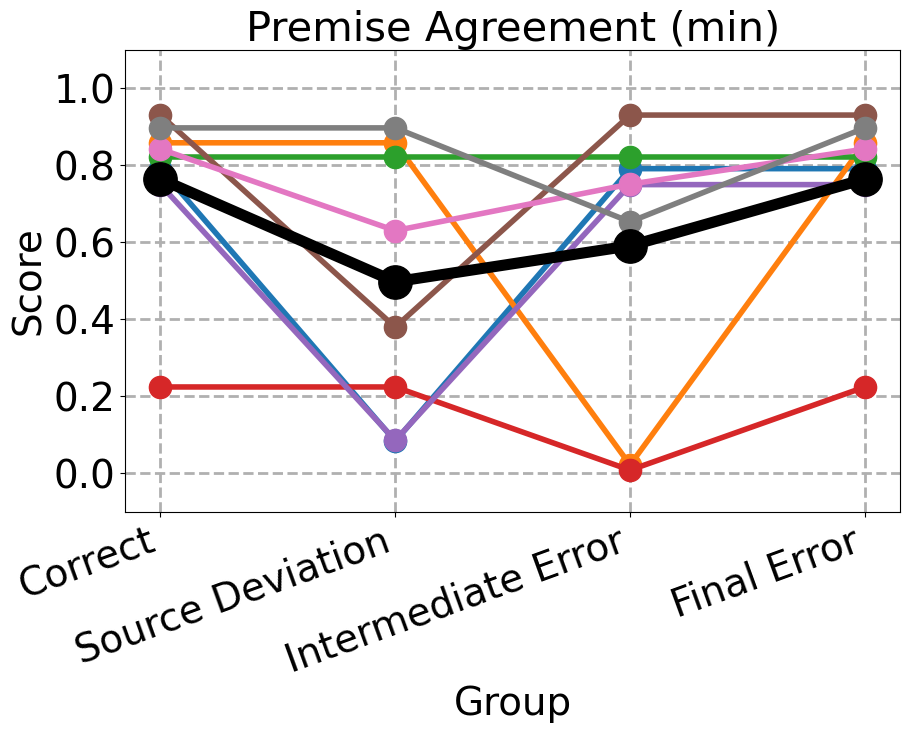


Group Means:
label
Correct               0.763629
Source Deviation      0.496771
Intermediate Error    0.590138
Final Error           0.763629
dtype: float64

Group STDs:
label
Correct               0.225524
Source Deviation      0.346843
Intermediate Error    0.363850
Final Error           0.225524
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 1.824416539615033
 P-value: 0.09302785210685385

Mann-Whitney U Test:
 Test Statistic: 46.0
 P-value: 0.15503437250919233

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04871759506415515
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.1463134606428047
 P-value: 0.27459452655284566

Mann-Whitney U Test:
 Test Statistic: 46.0
 P-value: 0.15503437250919233

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.048

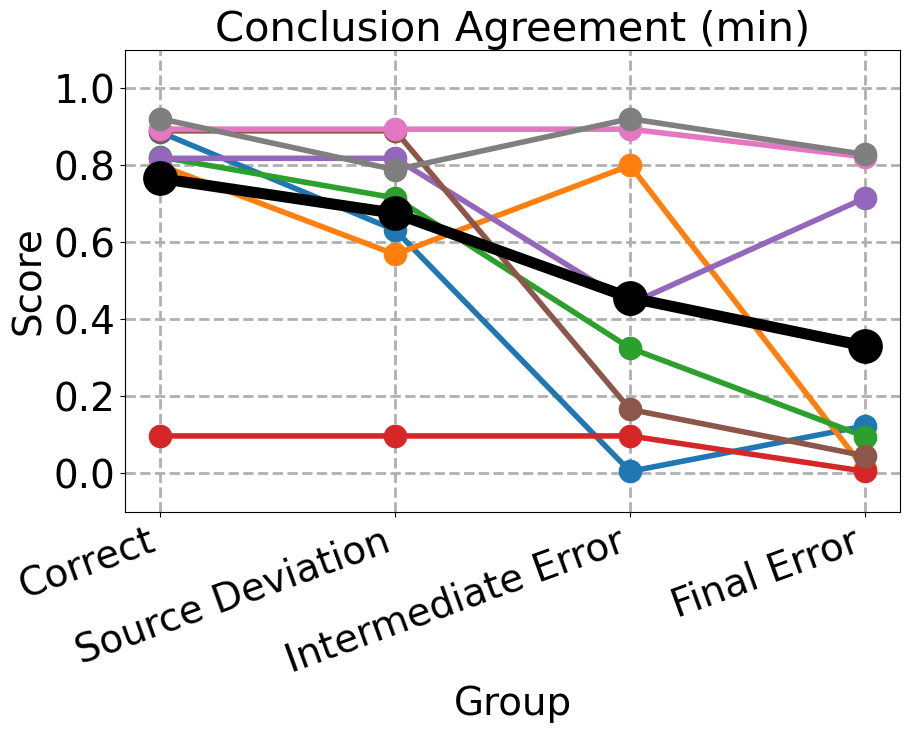


Group Means:
label
Correct               0.765153
Source Deviation      0.674558
Intermediate Error    0.455266
Final Error           0.329813
dtype: float64

Group STDs:
label
Correct               0.273722
Source Deviation      0.260804
Intermediate Error    0.370315
Final Error           0.382647
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.677752619032006
 P-value: 0.5090007257105855

Mann-Whitney U Test:
 Test Statistic: 45.0
 P-value: 0.187959068257727

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04871759506415515
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.9033669985811346
 P-value: 0.07956004668280188

Mann-Whitney U Test:
 Test Statistic: 45.0
 P-value: 0.187959068257727

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04871759

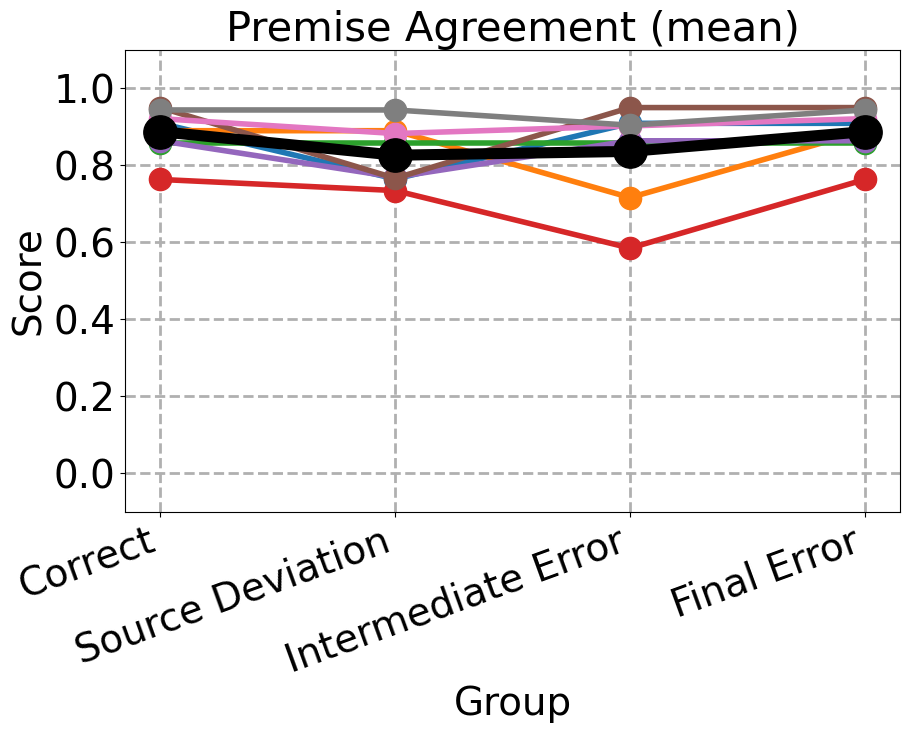


Group Means:
label
Correct               0.886751
Source Deviation      0.825469
Intermediate Error    0.835444
Final Error           0.886751
dtype: float64

Group STDs:
label
Correct               0.060348
Source Deviation      0.076706
Intermediate Error    0.123076
Final Error           0.060348
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 1.775932627832173
 P-value: 0.09867481789405126

Mann-Whitney U Test:
 Test Statistic: 46.5
 P-value: 0.14060328916956966

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.029523215949937873
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.0586635866303917
 P-value: 0.31422164479665876

Mann-Whitney U Test:
 Test Statistic: 40.0
 P-value: 0.4295368450634365

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.048

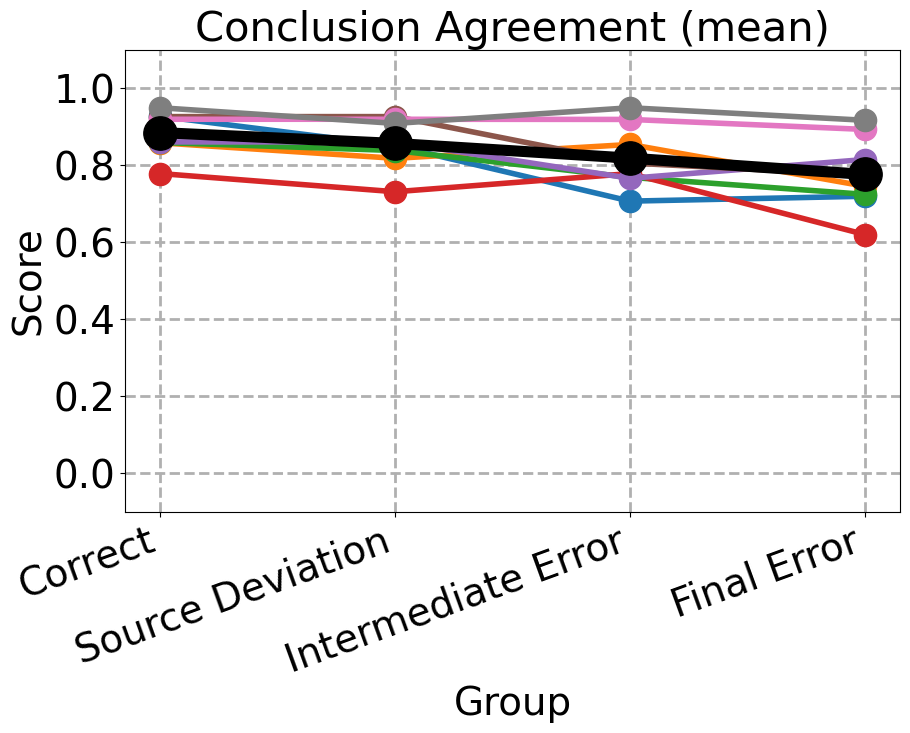


Group Means:
label
Correct               0.884239
Source Deviation      0.856047
Intermediate Error    0.817905
Final Error           0.775536
dtype: float64

Group STDs:
label
Correct               0.056250
Source Deviation      0.064517
Intermediate Error    0.082785
Final Error           0.097203
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.9315928483947414
 P-value: 0.36762251578112504

Mann-Whitney U Test:
 Test Statistic: 43.5
 P-value: 0.2469506284886106

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.029523215949937873
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.8745672840009089
 P-value: 0.08473757255771974

Mann-Whitney U Test:
 Test Statistic: 50.0
 P-value: 0.06568366858113087

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.01

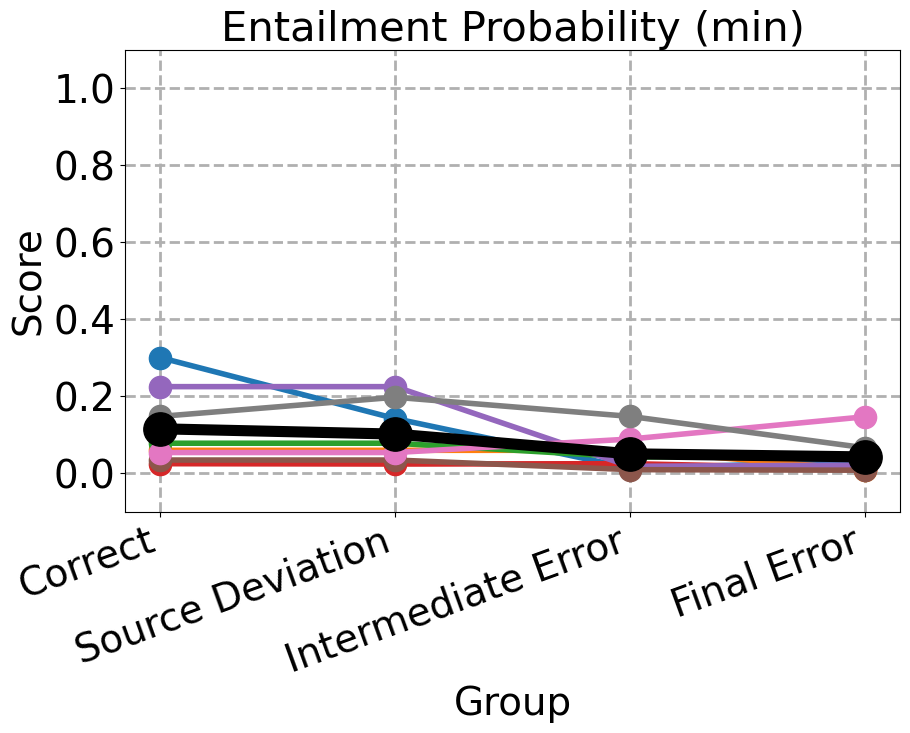


Group Means:
label
Correct               0.114864
Source Deviation      0.101174
Intermediate Error    0.049881
Final Error           0.041877
dtype: float64

Group STDs:
label
Correct               0.100242
Source Deviation      0.076702
Intermediate Error    0.047607
Final Error           0.046692
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.30676428871451455
 P-value: 0.7638429049644624

Mann-Whitney U Test:
 Test Statistic: 34.5
 P-value: 0.8330288937195214

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.5663316882029108
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.656258285982648
 P-value: 0.12865207616693308

Mann-Whitney U Test:
 Test Statistic: 47.5
 P-value: 0.11438157270759665

Wilcoxon Signed Rank test:
 Test Statistic: 5.0
 P-value: 0.14

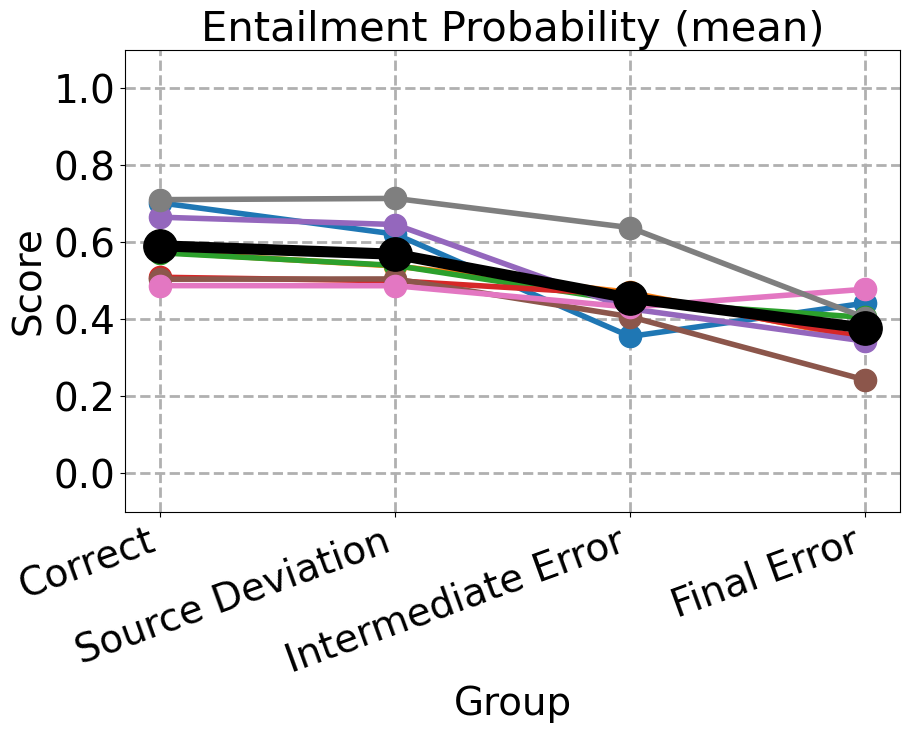


Group Means:
label
Correct               0.590129
Source Deviation      0.568283
Intermediate Error    0.454192
Final Error           0.376389
dtype: float64

Group STDs:
label
Correct               0.090894
Source Deviation      0.081988
Intermediate Error    0.082331
Final Error           0.072270
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.5047976311923551
 P-value: 0.6216351289354787

Mann-Whitney U Test:
 Test Statistic: 37.0
 P-value: 0.6453768453768453

Wilcoxon Signed Rank test:
 Test Statistic: 5.0
 P-value: 0.078125
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 3.1351650527243744
 P-value: 0.007377280674668615

Mann-Whitney U Test:
 Test Statistic: 59.0
 P-value: 0.0029526029526029526

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
>

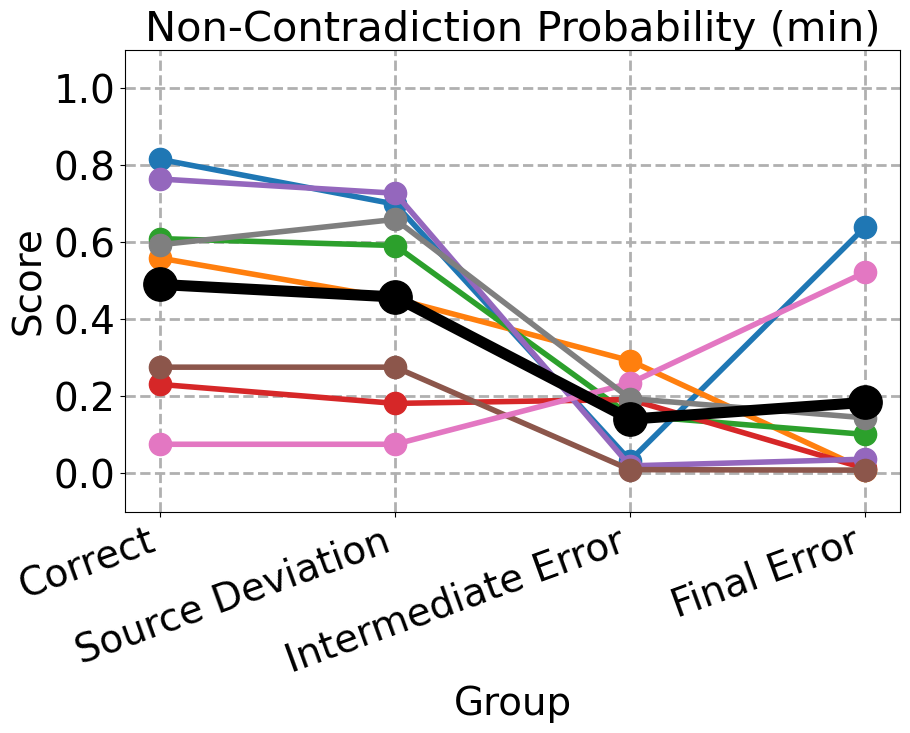


Group Means:
label
Correct               0.489744
Source Deviation      0.457255
Intermediate Error    0.139906
Final Error           0.183503
dtype: float64

Group STDs:
label
Correct               0.266146
Source Deviation      0.252203
Intermediate Error    0.107457
Final Error           0.251285
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.2506192233495247
 P-value: 0.8057595563006116

Mann-Whitney U Test:
 Test Statistic: 35.0
 P-value: 0.7925972289255464

Wilcoxon Signed Rank test:
 Test Statistic: 6.0
 P-value: 0.1365794180581274
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 3.447459516916824
 P-value: 0.007042382726367359

Mann-Whitney U Test:
 Test Statistic: 56.0
 P-value: 0.010411810411810413

Wilcoxon Signed Rank test:
 Test Statistic: 2.0
 P-value: 0.0

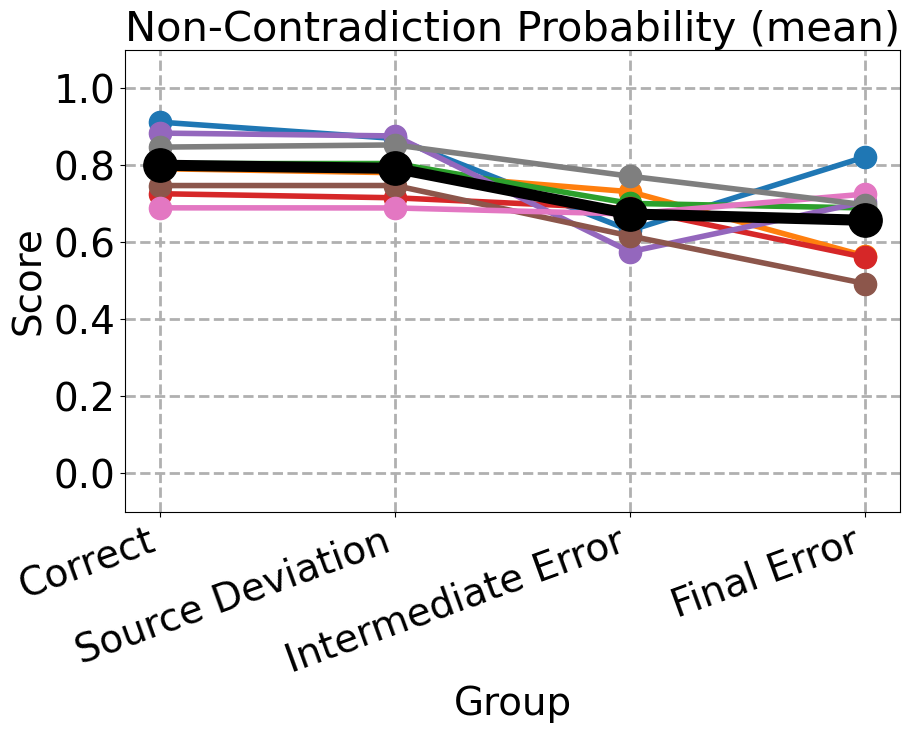


Group Means:
label
Correct               0.799516
Source Deviation      0.791341
Intermediate Error    0.672818
Final Error           0.656446
dtype: float64

Group STDs:
label
Correct               0.077737
Source Deviation      0.071211
Intermediate Error    0.063957
Final Error           0.107864
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.21931739641315667
 P-value: 0.8295921029702781

Mann-Whitney U Test:
 Test Statistic: 34.0
 P-value: 0.8784770784770783

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.1484375
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 3.5598665252134714
 P-value: 0.003305733153136027

Mann-Whitney U Test:
 Test Statistic: 58.0
 P-value: 0.004662004662004662

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125


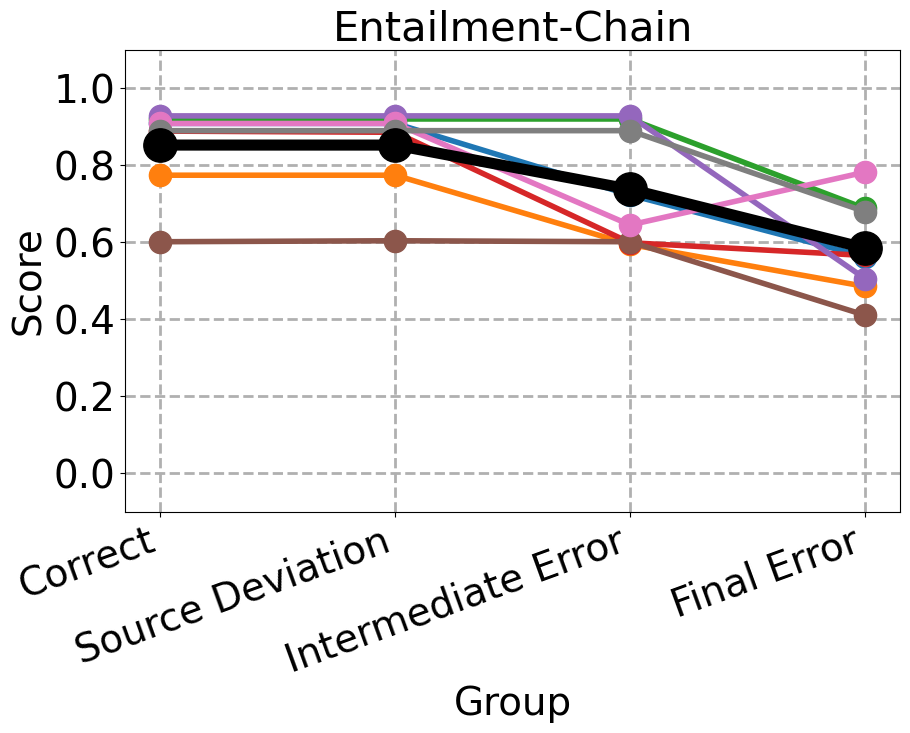


Group Means:
label
Correct               0.851861
Source Deviation      0.851795
Intermediate Error    0.736949
Final Error           0.584391
dtype: float64

Group STDs:
label
Correct               0.112462
Source Deviation      0.111499
Intermediate Error    0.151212
Final Error           0.122955
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.0011666696289773636
 P-value: 0.9990855950406049

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.9250518935055844
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.7247124876530933
 P-value: 0.10838552336970153

Mann-Whitney U Test:
 Test Statistic: 44.0
 P-value: 0.22577680833270375

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04871759506415

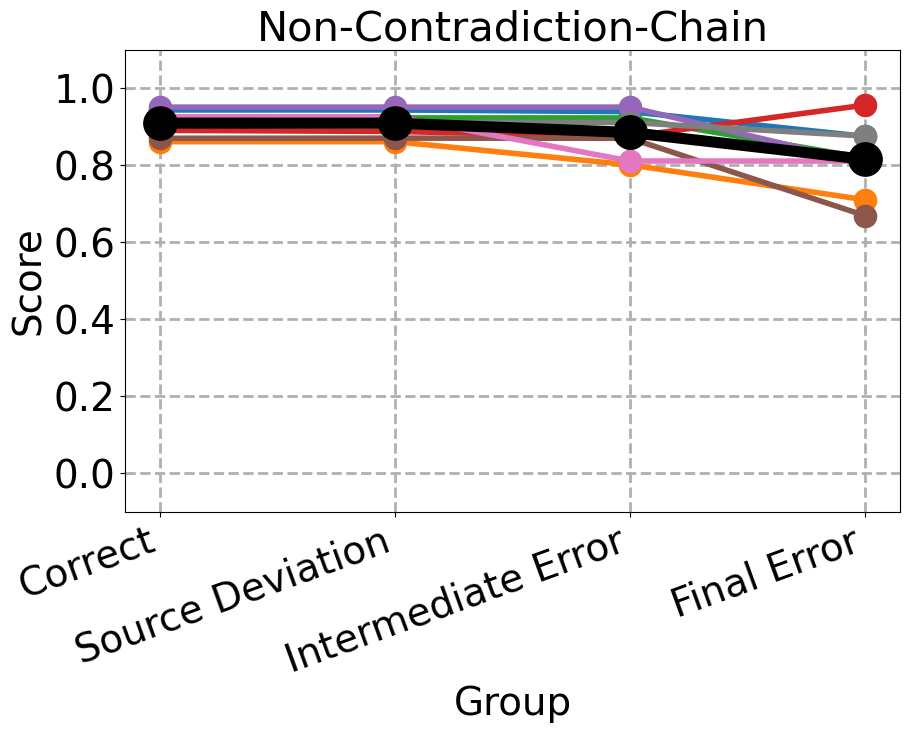


Group Means:
label
Correct               0.909009
Source Deviation      0.908693
Intermediate Error    0.884537
Final Error           0.814668
dtype: float64

Group STDs:
label
Correct               0.032914
Source Deviation      0.033103
Intermediate Error    0.056417
Final Error           0.092264
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.019154813494099202
 P-value: 0.9849879301138837

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.9250518935055844
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.0597204286465942
 P-value: 0.3114550299880946

Mann-Whitney U Test:
 Test Statistic: 39.0
 P-value: 0.4935627897033893

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04871759506415515

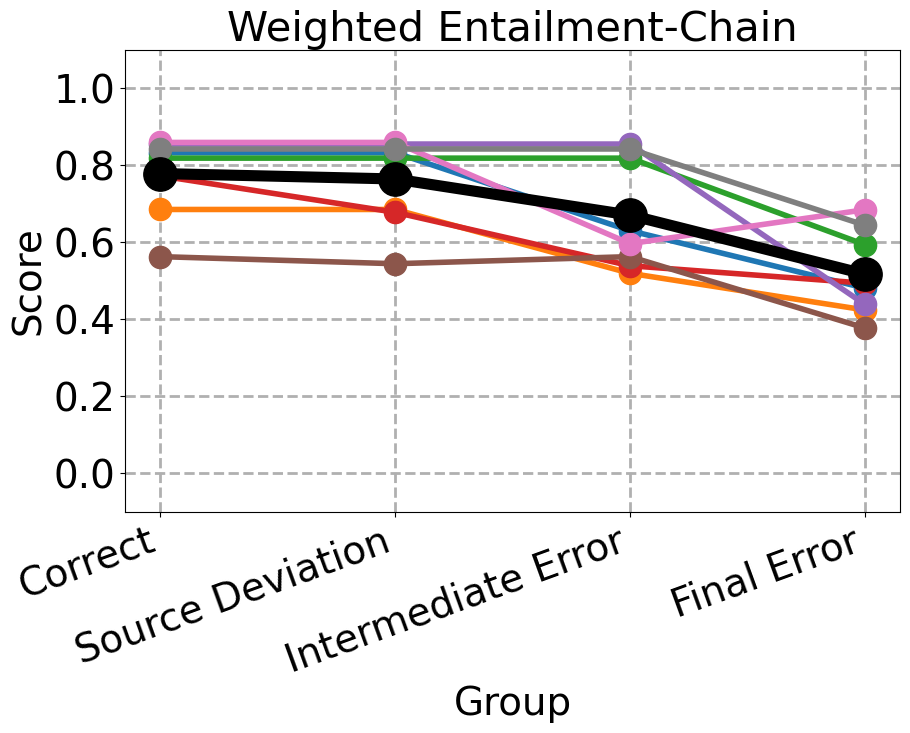


Group Means:
label
Correct               0.777890
Source Deviation      0.763759
Intermediate Error    0.669809
Final Error           0.516504
dtype: float64

Group STDs:
label
Correct               0.104412
Source Deviation      0.115343
Intermediate Error    0.143625
Final Error           0.111023
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.2568917431823092
 P-value: 0.8010356314823439

Mann-Whitney U Test:
 Test Statistic: 34.0
 P-value: 0.8742746708438139

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.15822064245182277
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.7216091860347489
 P-value: 0.10923147833934155

Mann-Whitney U Test:
 Test Statistic: 46.0
 P-value: 0.15503437250919233

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0

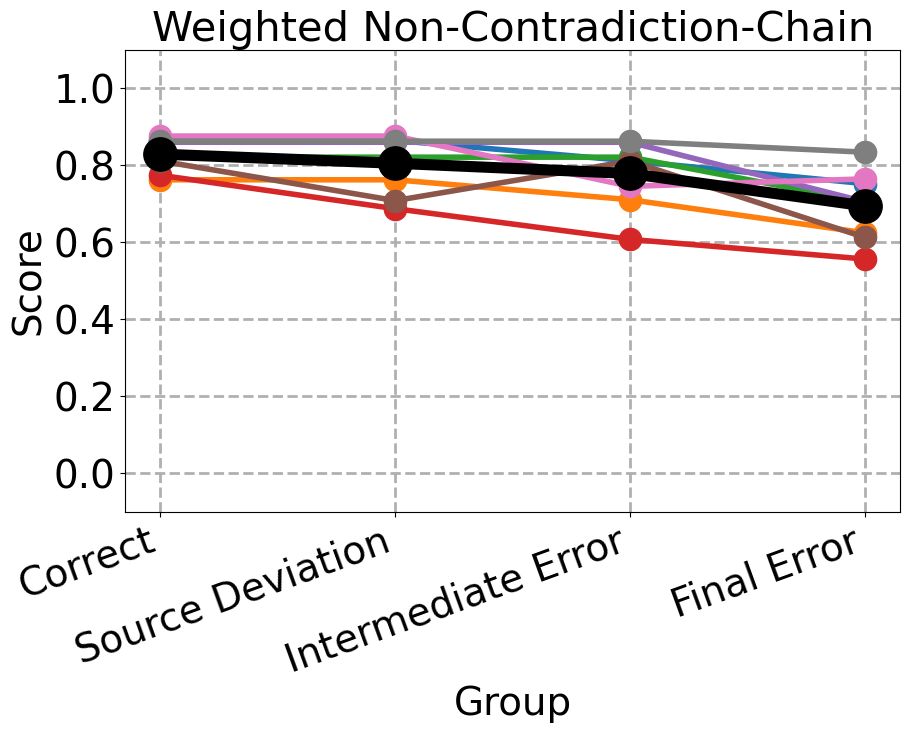


Group Means:
label
Correct               0.828272
Source Deviation      0.804557
Intermediate Error    0.778021
Final Error           0.693689
dtype: float64

Group STDs:
label
Correct               0.043730
Source Deviation      0.075789
Intermediate Error    0.086671
Final Error           0.091482
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.7665633669665282
 P-value: 0.45919983390068986

Mann-Whitney U Test:
 Test Statistic: 36.0
 P-value: 0.7119741981650669

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.15822064245182277
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.4640757332960672
 P-value: 0.17288202416359744

Mann-Whitney U Test:
 Test Statistic: 45.0
 P-value: 0.187959068257727

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.04

In [5]:
# Load results
dict_IE_corr = json.load(open("IE/correct/evaluation_llognet/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_llognet/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_llognet/infer_emotion.json"))

task_list = [
    'source_grounding',
    'step_entailment',
    'chain_entailment'
]

ignore = ['label', 'id']

for i, task in enumerate(task_list):

    print("\n" +"#" * 50)
    print(f"\n >>>>>> Evaluate {format_string(task)} <<<<<<")

    # Convert dicts to pandas dataframes
    df_corr = create_df_from_result(dict_IE_corr, label=0, task=task)
    df_source_dev = create_df_from_result(dict_IE_source_dev, label=1, task=task)
    df_wrong_inter = create_df_from_result(dict_IE_wrong_inter, label=2, task=task)
    df_wrong_final = create_df_from_result(dict_IE_wrong_final, label=3, task=task)
    
    # Set labels
    df_corr["label"] = "Correct"
    df_source_dev["label"] = "Source Deviation"
    df_wrong_inter["label"] = "Intermediate Error"
    df_wrong_final["label"] = "Final Error"

    # Concatenate dataframes
    df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)

    metrics = [c for c in df.columns.to_list() if c not in ignore]

    test_scores(df, metrics)


##################################################

 >>>>>> Evaluate Source Grounding <<<<<<

##################################################

>>> Metric: Premise Agreement (min)
 (min)


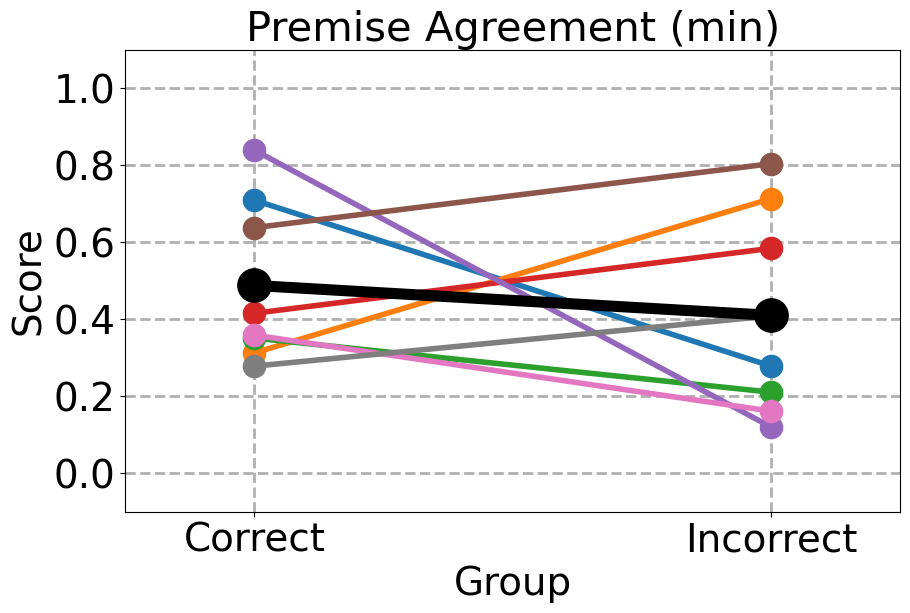


Group Means:
label
Correct      0.487747
Incorrect    0.410015
dtype: float64

Group STDs:
label
Correct      0.210538
Incorrect    0.261967
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.6541773767318858
 P-value: 0.5240824578900269

Mann-Whitney U Test:
 Test Statistic: 40.0
 P-value: 0.4418026418026417

Wilcoxon Signed Rank test:
 Test Statistic: 14.0
 P-value: 0.640625
> NO statistically significant difference

##################################################

>>> Metric: Conclusion Agreement (min)
 (min)


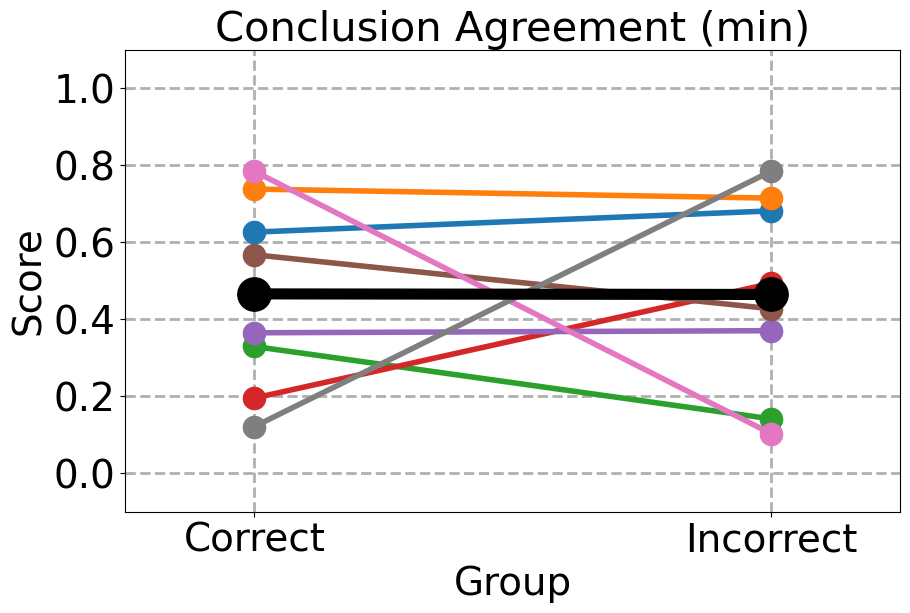


Group Means:
label
Correct      0.465800
Incorrect    0.464322
dtype: float64

Group STDs:
label
Correct      0.248599
Incorrect    0.255796
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.011718713347983592
 P-value: 0.9908155249168484

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 17.0
 P-value: 0.9453125
> NO statistically significant difference

##################################################

>>> Metric: Premise Agreement (mean)
(mean)


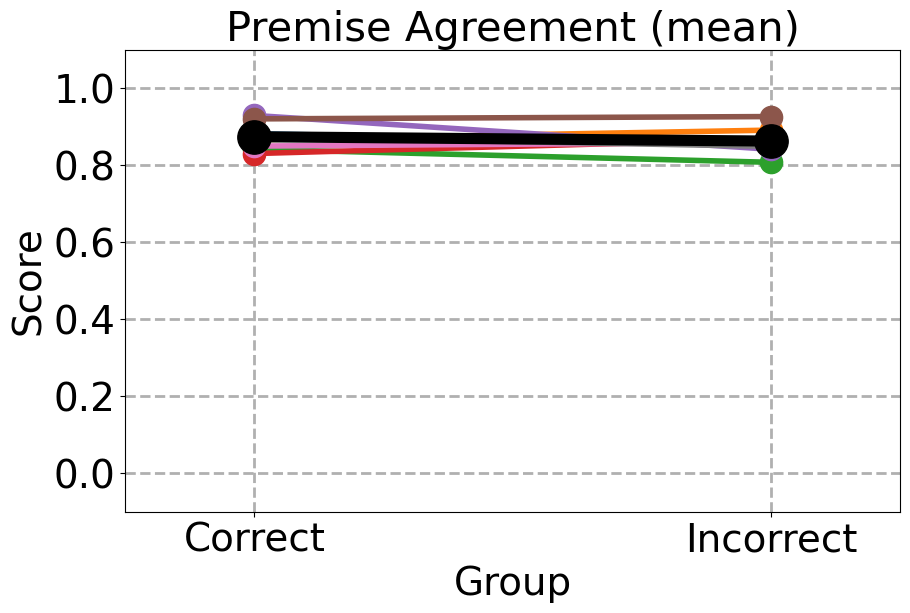


Group Means:
label
Correct      0.874041
Incorrect    0.862741
dtype: float64

Group STDs:
label
Correct      0.035622
Incorrect    0.035043
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.6396218392546248
 P-value: 0.5327488203837207

Mann-Whitney U Test:
 Test Statistic: 37.0
 P-value: 0.6453768453768453

Wilcoxon Signed Rank test:
 Test Statistic: 15.0
 P-value: 0.7421875
> NO statistically significant difference

##################################################

>>> Metric: Conclusion Agreement (mean)
(mean)


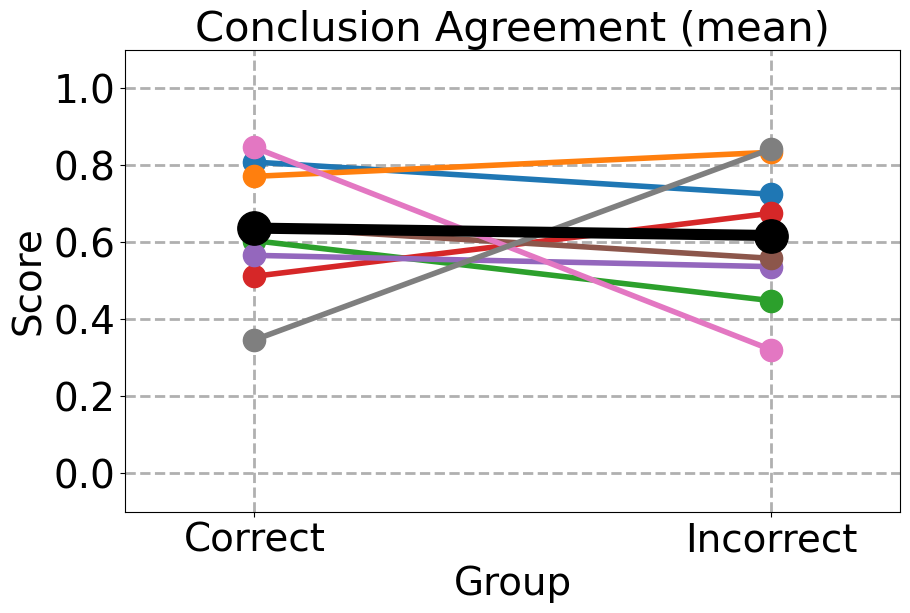


Group Means:
label
Correct      0.636730
Incorrect    0.617444
dtype: float64

Group STDs:
label
Correct      0.168005
Incorrect    0.184670
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.2184909422536932
 P-value: 0.8302272456650359

Mann-Whitney U Test:
 Test Statistic: 35.0
 P-value: 0.7984459984459983

Wilcoxon Signed Rank test:
 Test Statistic: 15.0
 P-value: 0.7421875
> NO statistically significant difference

##################################################

 >>>>>> Evaluate Step Entailment <<<<<<

##################################################

>>> Metric: Entailment Probability (min)
 (min)


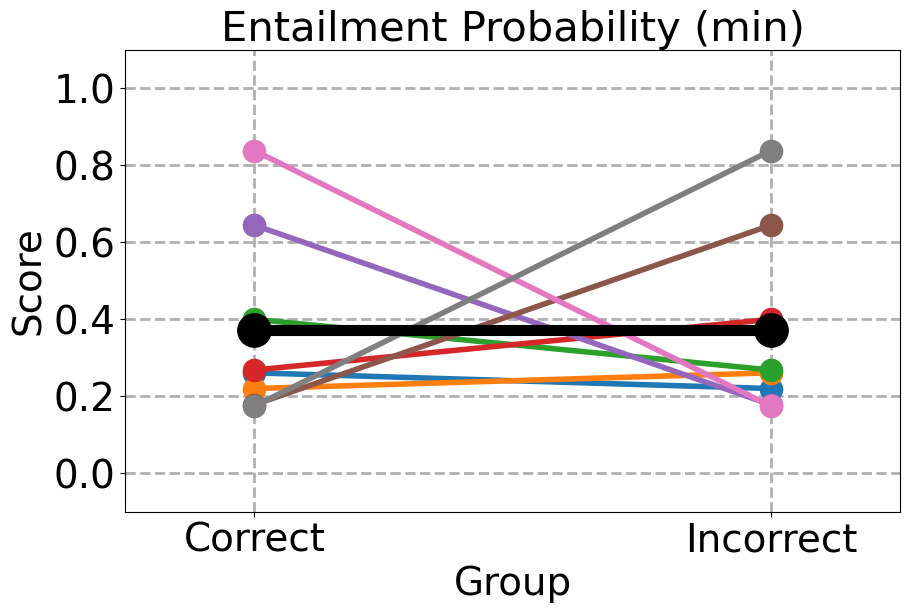


Group Means:
label
Correct      0.372877
Incorrect    0.372877
dtype: float64

Group STDs:
label
Correct      0.2436
Incorrect    0.2436
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Entailment Probability (mean)
(mean)


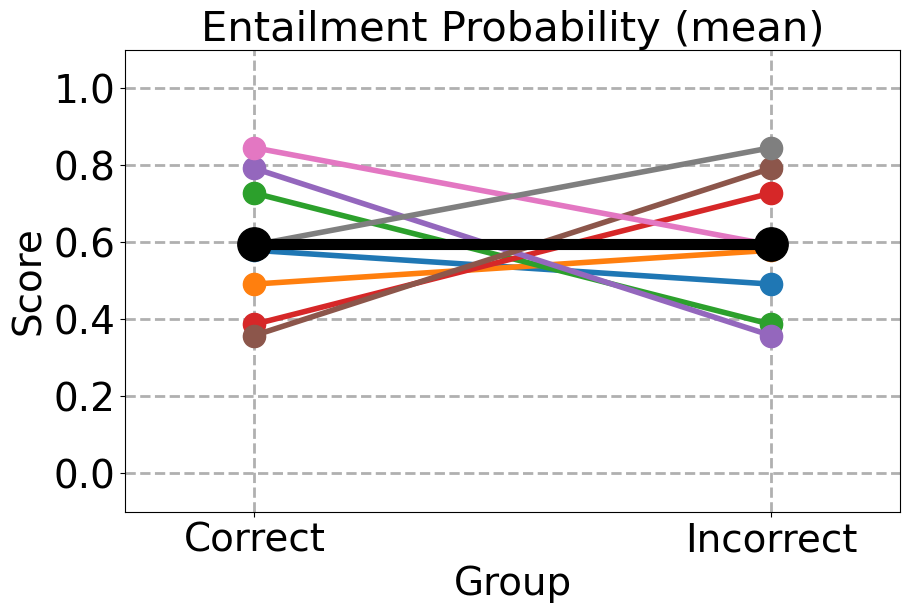


Group Means:
label
Correct      0.596583
Incorrect    0.596583
dtype: float64

Group STDs:
label
Correct      0.181151
Incorrect    0.181151
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Non Contradiction Probability (min)
 (min)


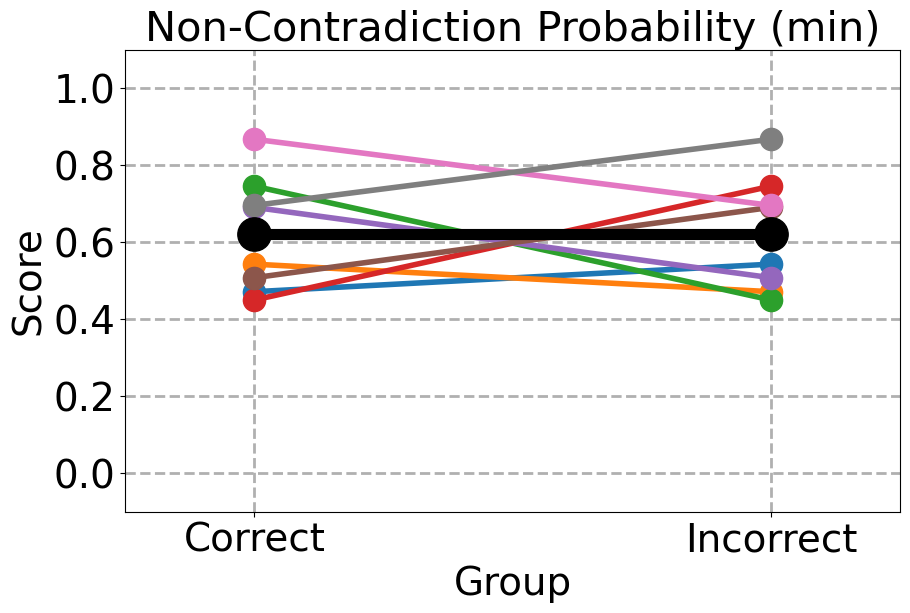


Group Means:
label
Correct      0.62144
Incorrect    0.62144
dtype: float64

Group STDs:
label
Correct      0.149884
Incorrect    0.149884
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Non Contradiction Probability (mean)
(mean)


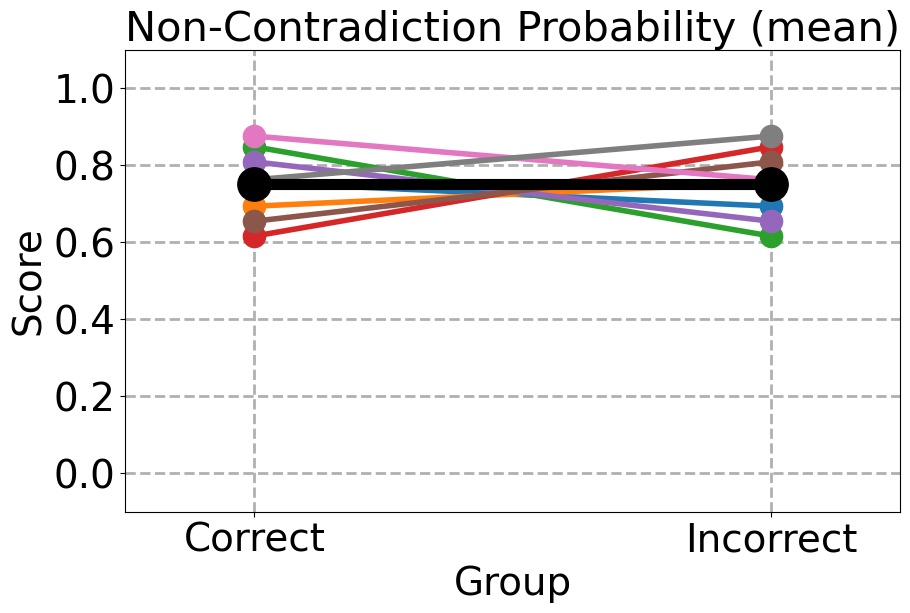


Group Means:
label
Correct      0.751821
Incorrect    0.751821
dtype: float64

Group STDs:
label
Correct      0.092047
Incorrect    0.092047
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

 >>>>>> Evaluate Chain Entailment <<<<<<

##################################################

>>> Metric: Entailment Chain (max)
 (max)


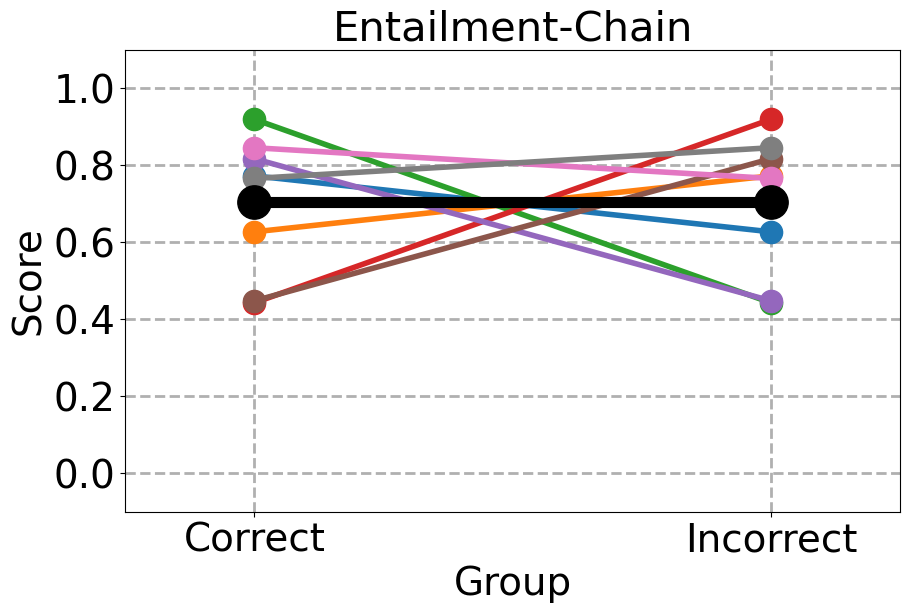


Group Means:
label
Correct      0.704624
Incorrect    0.704624
dtype: float64

Group STDs:
label
Correct      0.180293
Incorrect    0.180293
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Non Contradiction Chain (max)
 (max)


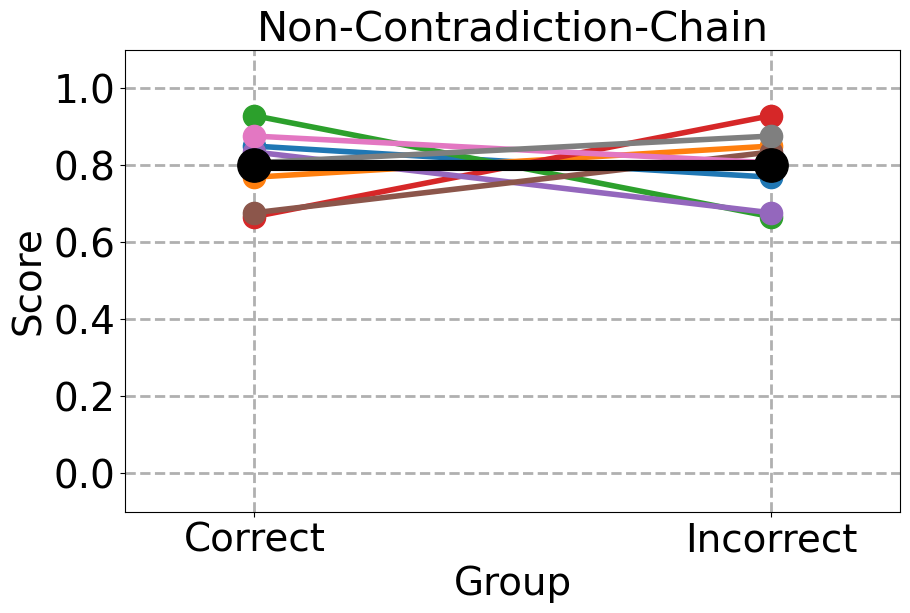


Group Means:
label
Correct      0.800851
Incorrect    0.800851
dtype: float64

Group STDs:
label
Correct      0.092629
Incorrect    0.092629
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Weighted Entailment Chain (max)
 (max)


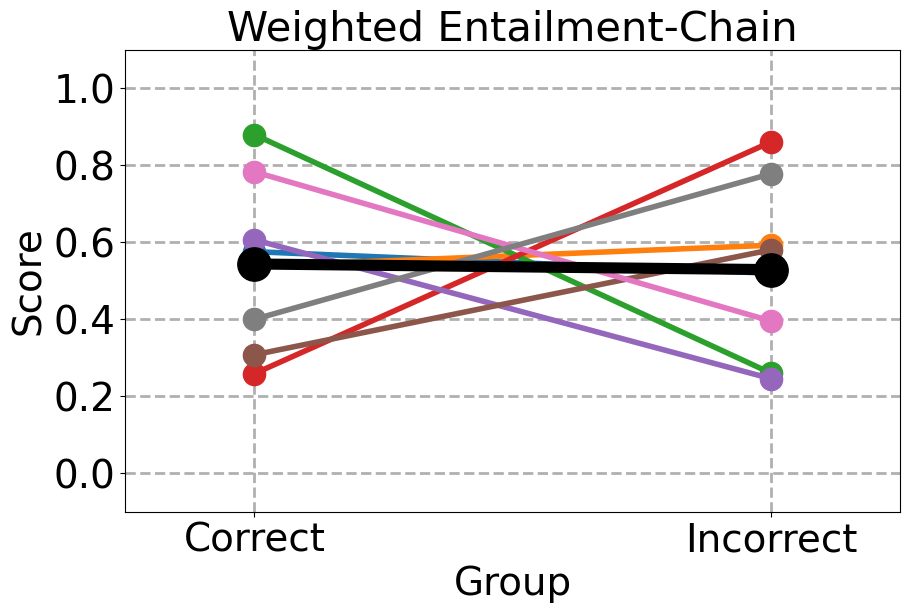


Group Means:
label
Correct      0.543490
Incorrect    0.528855
dtype: float64

Group STDs:
label
Correct      0.218047
Incorrect    0.223306
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.13263500095072647
 P-value: 0.8963706019082656

Mann-Whitney U Test:
 Test Statistic: 35.0
 P-value: 0.7984459984459983

Wilcoxon Signed Rank test:
 Test Statistic: 16.0
 P-value: 0.84375
> NO statistically significant difference

##################################################

>>> Metric: Weighted Non Contradiction Chain (max)
 (max)


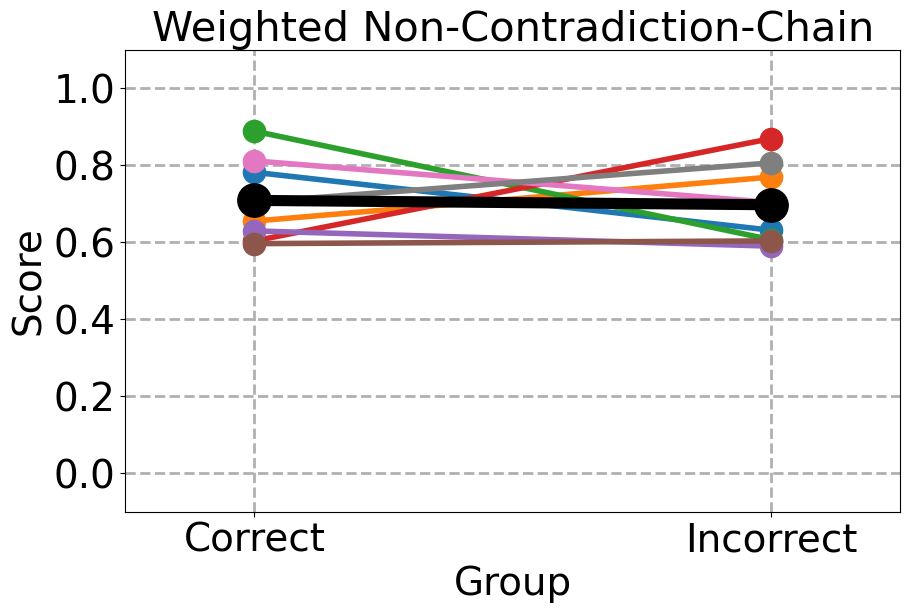


Group Means:
label
Correct      0.708637
Incorrect    0.697366
dtype: float64

Group STDs:
label
Correct      0.107641
Incorrect    0.106582
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.21045964491900934
 P-value: 0.83634155017558

Mann-Whitney U Test:
 Test Statistic: 35.0
 P-value: 0.7984459984459983

Wilcoxon Signed Rank test:
 Test Statistic: 16.0
 P-value: 0.84375
> NO statistically significant difference


In [6]:
# Load results
dict_KP_corr = json.load(open("KP/correct/evaluation_llognet/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_llognet/knowledge_perception.json"))

task_list = [
    'source_grounding',
    'step_entailment',
    'chain_entailment'
]

ignore = ['label', 'id']

for i, task in enumerate(task_list):
    print("\n" +"#" * 50)
    print(f"\n >>>>>> Evaluate {format_string(task)} <<<<<<")
    
    # Convert dicts to pandas dataframes
    df_corr = create_df_from_result(dict_KP_corr, label=0, task=task)
    df_incorr = create_df_from_result(dict_KP_incorr, label=1, task=task)
    
    # Set labels
    df_corr["label"] = "Correct"
    df_incorr["label"] = "Incorrect"
    
    # Concatenate dataframes
    df = pd.concat([df_corr, df_incorr], ignore_index=True)
    
    metrics = [c for c in df.columns.to_list() if c not in ignore]
    
    test_scores(df, metrics, type="KP")

## ROSCOE

['label', 'id', 'entailment-chain (max)', 'non-contradiction-chain (max)', 'weighted_entailment-chain (max)', 'weighted_non-contradiction-chain (max)']

##################################################

 >>>>>> Evaluate Semantic Alignment <<<<<<

##################################################

>>> Metric: Faithfulness Step
s_step


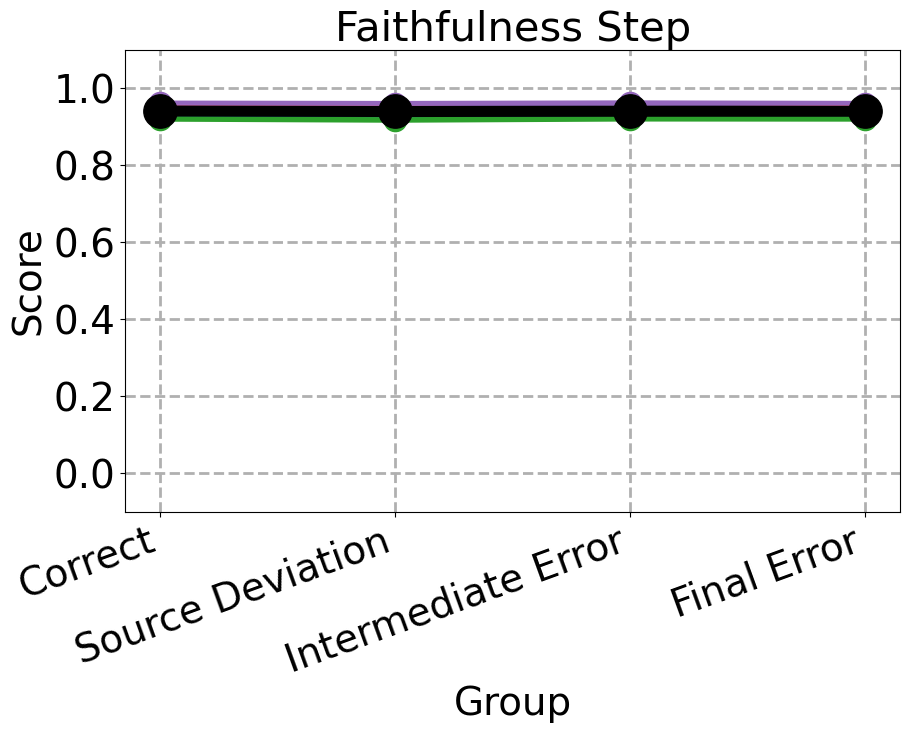


Group Means:
label
Correct               0.940365
Source Deviation      0.939053
Intermediate Error    0.939769
Final Error           0.939761
dtype: float64

Group STDs:
label
Correct               0.012294
Source Deviation      0.012639
Intermediate Error    0.012063
Final Error           0.012188
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.21045084924607177
 P-value: 0.836350287733456

Mann-Whitney U Test:
 Test Statistic: 37.0
 P-value: 0.6453768453768453

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.09783086046771793
 P-value: 0.9234539401085701

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 14.0
 P-value: 0.640625
> NO statistically sig

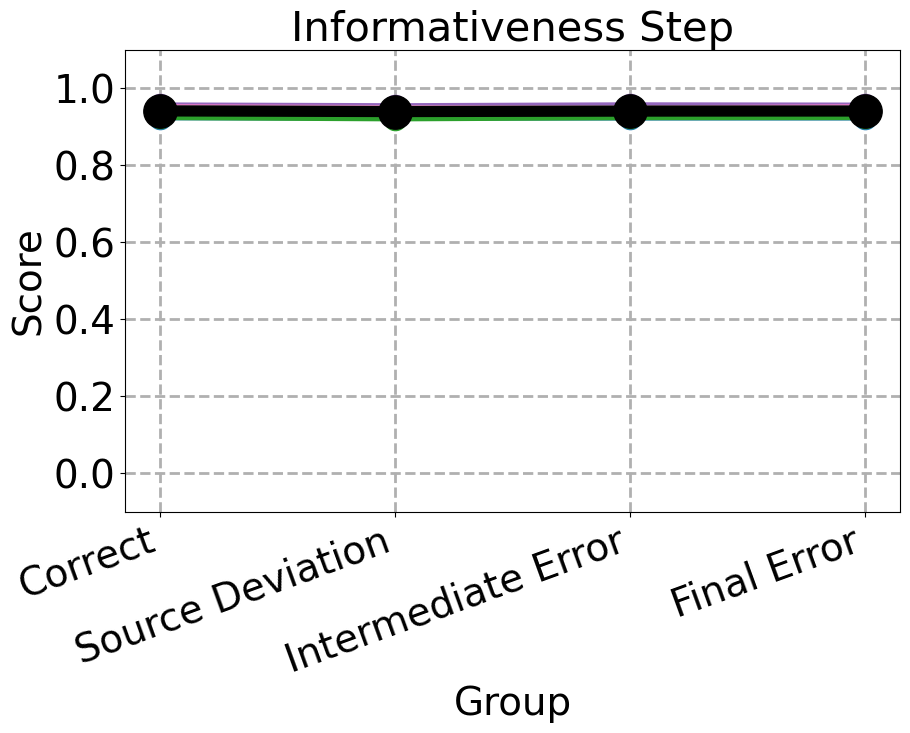


Group Means:
label
Correct               0.940470
Source Deviation      0.938761
Intermediate Error    0.939956
Final Error           0.940168
dtype: float64

Group STDs:
label
Correct               0.011813
Source Deviation      0.011763
Intermediate Error    0.011616
Final Error           0.011801
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.2899537927968262
 P-value: 0.7761018692999911

Mann-Whitney U Test:
 Test Statistic: 38.0
 P-value: 0.5737373737373737

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.08779068347483789
 P-value: 0.9312867795165574

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 12.0
 P-value: 0.4609375
> NO st

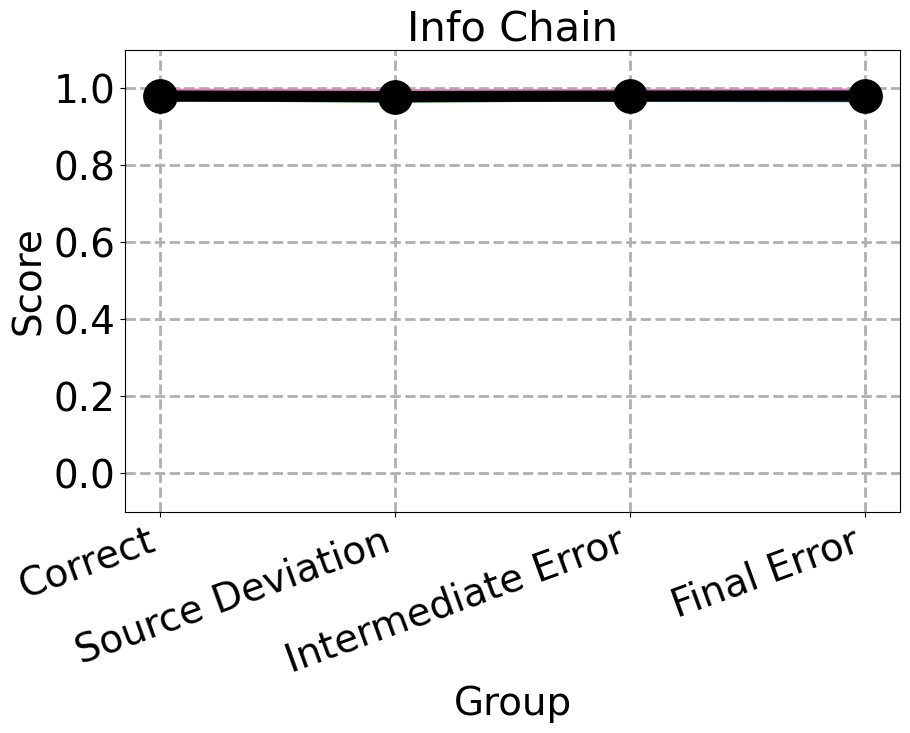


Group Means:
label
Correct               0.979153
Source Deviation      0.977777
Intermediate Error    0.979181
Final Error           0.979311
dtype: float64

Group STDs:
label
Correct               0.006768
Source Deviation      0.007135
Intermediate Error    0.006599
Final Error           0.007102
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.3957571701533381
 P-value: 0.6982658860829358

Mann-Whitney U Test:
 Test Statistic: 39.0
 P-value: 0.5053613053613053

Wilcoxon Signed Rank test:
 Test Statistic: 2.0
 P-value: 0.0234375
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: -0.008440407107540782
 P-value: 0.9933847797179676

Mann-Whitney U Test:
 Test Statistic: 29.0
 P-value: 0.7984459984459983

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO stati

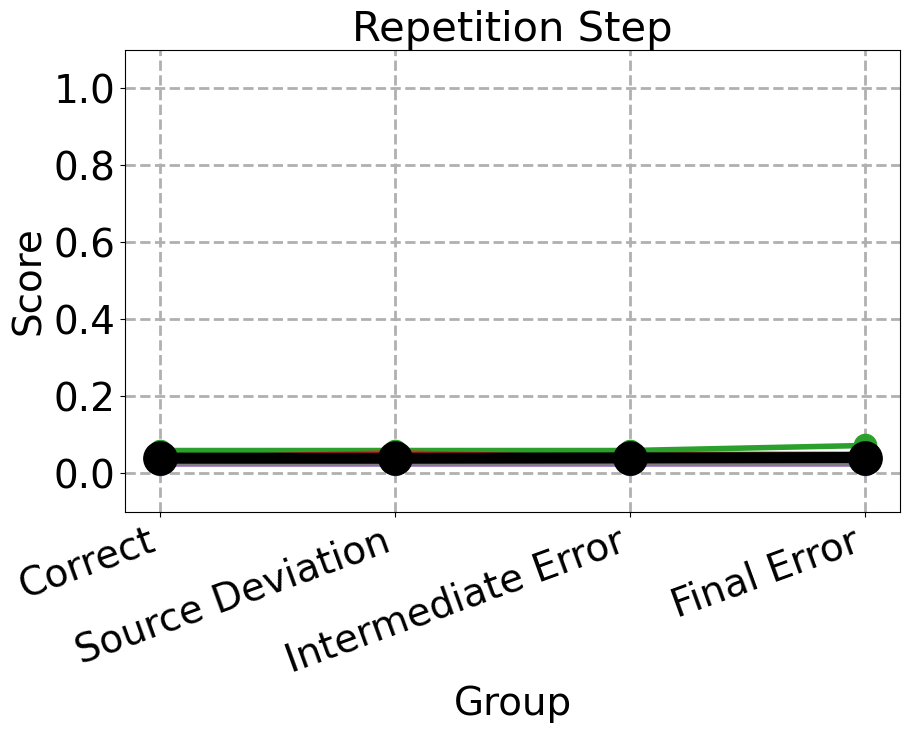


Group Means:
label
Correct               0.038644
Source Deviation      0.038505
Intermediate Error    0.039252
Final Error           0.040282
dtype: float64

Group STDs:
label
Correct               0.012016
Source Deviation      0.012545
Intermediate Error    0.011588
Final Error           0.015490
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.02275471638712768
 P-value: 0.9821676622268801

Mann-Whitney U Test:
 Test Statistic: 32.5
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 8.0
 P-value: 0.6820876871868882
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: -0.10294090649198563
 P-value: 0.9194717780481223

Mann-Whitney U Test:
 Test Statistic: 31.5
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.31731050786291415
> NO statisti

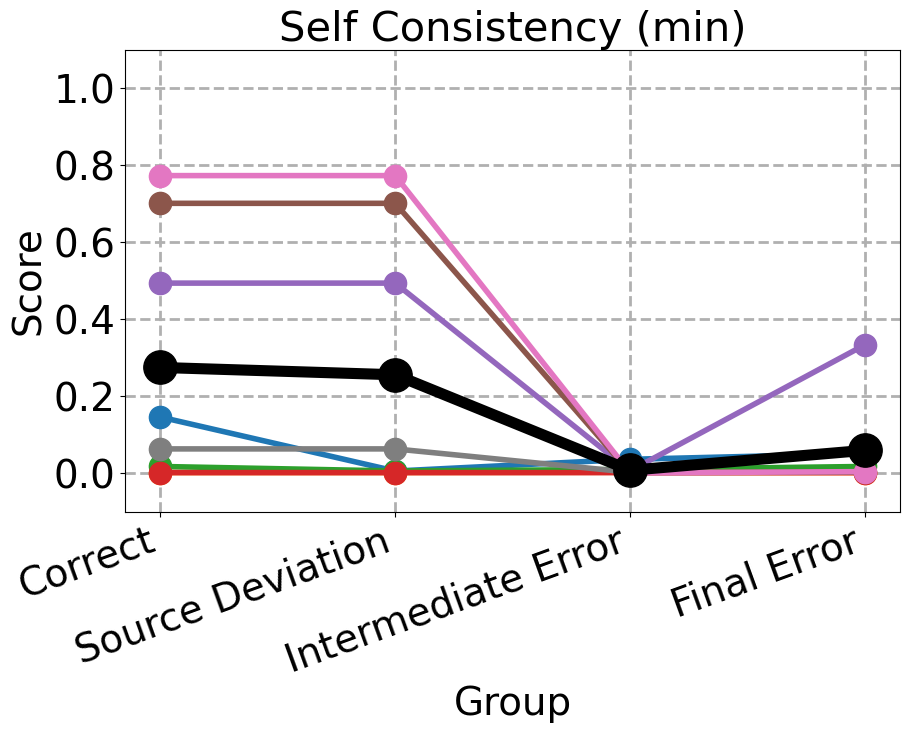


Group Means:
label
Correct               0.274217
Source Deviation      0.255216
Intermediate Error    0.007149
Final Error           0.058937
dtype: float64

Group STDs:
label
Correct               0.328340
Source Deviation      0.340955
Intermediate Error    0.011890
Final Error           0.113356
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.11353724782595828
 P-value: 0.9112189799329837

Mann-Whitney U Test:
 Test Statistic: 35.0
 P-value: 0.7919967945361512

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.15822064245182277
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 2.2991019520705893
 P-value: 0.05496868663333443

Mann-Whitney U Test:
 Test Statistic: 51.5
 P-value: 0.045839530165168445

Wilcoxon Signed Rank test:
 Test Statistic: 2.0
 P-value: 0

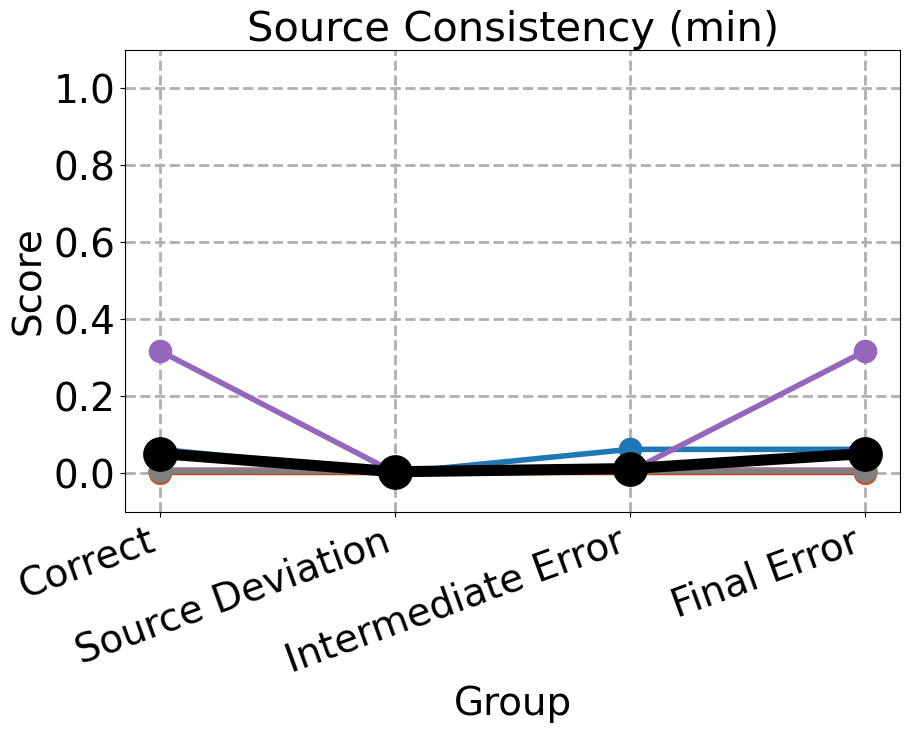


Group Means:
label
Correct               0.050549
Source Deviation      0.003295
Intermediate Error    0.011529
Final Error           0.050549
dtype: float64

Group STDs:
label
Correct               0.109284
Source Deviation      0.002829
Intermediate Error    0.020316
Final Error           0.109284
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 1.2225695516876642
 P-value: 0.2610033095798529

Mann-Whitney U Test:
 Test Statistic: 46.5
 P-value: 0.140016503197169

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.08536211245929524
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.9928830669984412
 P-value: 0.3517811845575885

Mann-Whitney U Test:
 Test Statistic: 37.0
 P-value: 0.635005519945619

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.15822

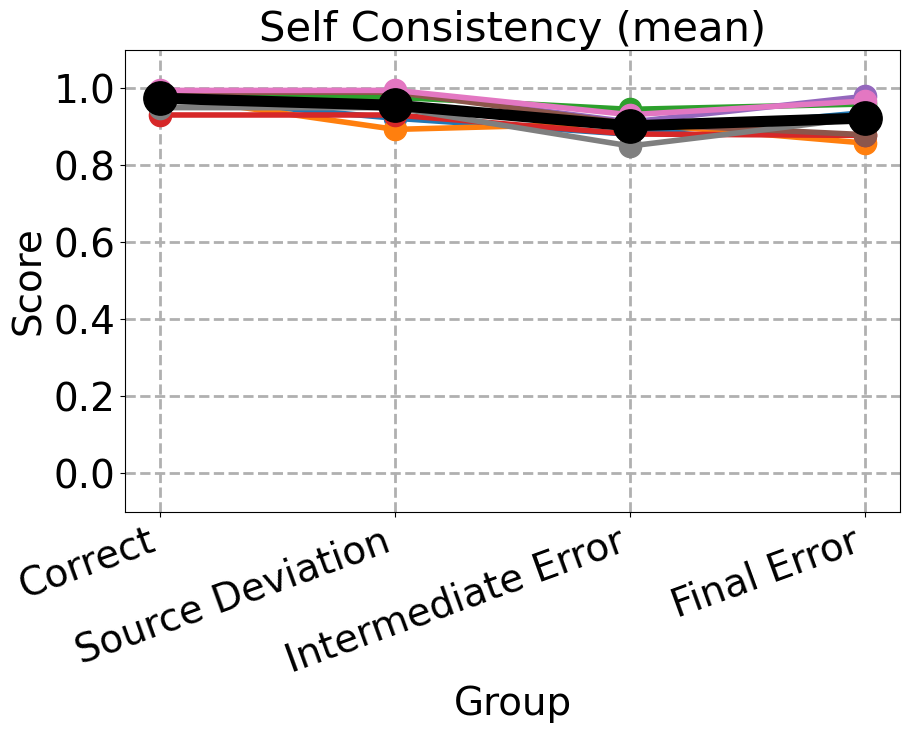


Group Means:
label
Correct               0.973509
Source Deviation      0.955209
Intermediate Error    0.901701
Final Error           0.921948
dtype: float64

Group STDs:
label
Correct               0.022401
Source Deviation      0.037851
Intermediate Error    0.030516
Final Error           0.045944
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 1.1768116328897245
 P-value: 0.2633244621475028

Mann-Whitney U Test:
 Test Statistic: 41.0
 P-value: 0.3822843822843822

Wilcoxon Signed Rank test:
 Test Statistic: 2.0
 P-value: 0.0234375
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 5.365242167889401
 P-value: 0.00013394741699884004

Mann-Whitney U Test:
 Test Statistic: 62.0
 P-value: 0.0006216006216006216

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
> 

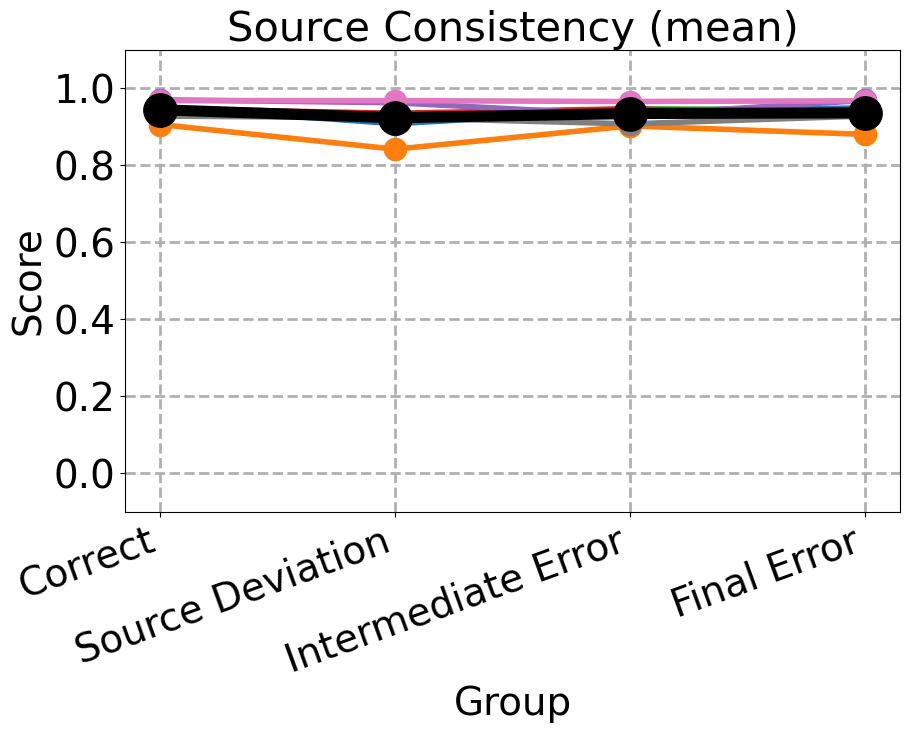


Group Means:
label
Correct               0.943501
Source Deviation      0.922852
Intermediate Error    0.933700
Final Error           0.935538
dtype: float64

Group STDs:
label
Correct               0.020945
Source Deviation      0.038804
Intermediate Error    0.021090
Final Error           0.028336
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 1.3245310112339155
 P-value: 0.21277052541708025

Mann-Whitney U Test:
 Test Statistic: 46.0
 P-value: 0.1605283605283605

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.9326861063501669
 P-value: 0.366789910369843

Mann-Whitney U Test:
 Test Statistic: 42.0
 P-value: 0.32820512820512815

Wilcoxon Signed Rank test:
 Test Statistic: 3.0
 P-value: 0.0390625
> Stati

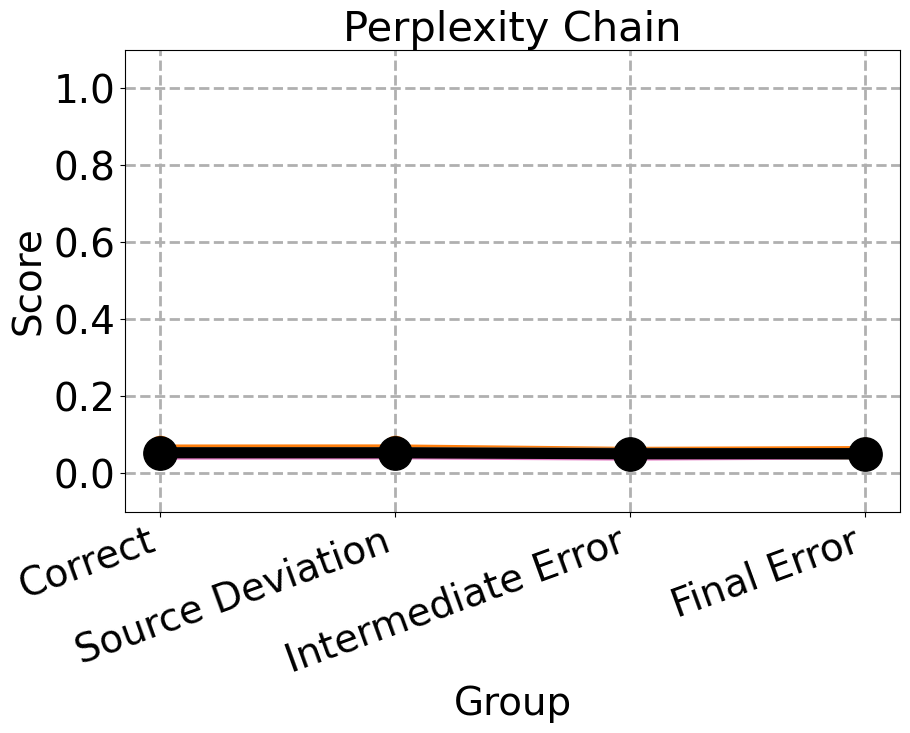


Group Means:
label
Correct               0.052595
Source Deviation      0.052547
Intermediate Error    0.049976
Final Error           0.050386
dtype: float64

Group STDs:
label
Correct               0.008725
Source Deviation      0.008813
Intermediate Error    0.007868
Final Error           0.007599
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.010899960072441602
 P-value: 0.991457081232846

Mann-Whitney U Test:
 Test Statistic: 31.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 16.0
 P-value: 0.84375
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.6304622655310497
 P-value: 0.5386541635816444

Mann-Whitney U Test:
 Test Statistic: 38.0
 P-value: 0.5737373737373737

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.0078125
> Stat

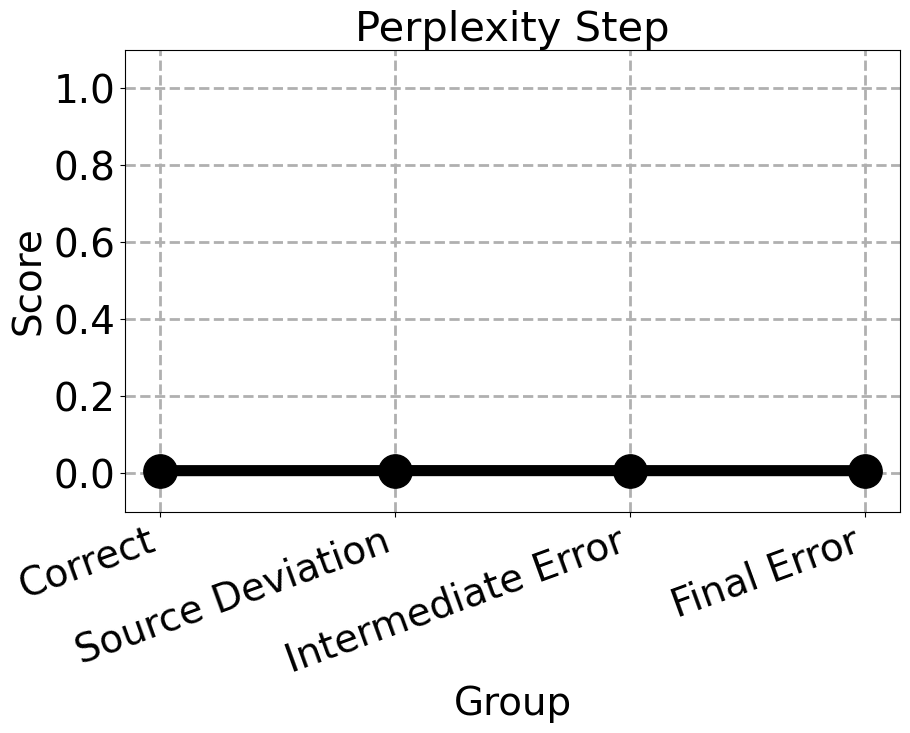


Group Means:
label
Correct               0.006150
Source Deviation      0.006285
Intermediate Error    0.006216
Final Error           0.006131
dtype: float64

Group STDs:
label
Correct               0.002397
Source Deviation      0.002515
Intermediate Error    0.002733
Final Error           0.002426
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: -0.11011257678188043
 P-value: 0.9138865308386199

Mann-Whitney U Test:
 Test Statistic: 30.0
 P-value: 0.8784770784770783

Wilcoxon Signed Rank test:
 Test Statistic: 14.0
 P-value: 0.640625
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: -0.051276864593641135
 P-value: 0.95984152514419

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 8.0
 P-value: 0.1953125
> N

In [7]:
# Load results
dict_IE_corr = json.load(open("IE/correct/evaluation_roscoe/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_roscoe/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_roscoe/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_roscoe/infer_emotion.json"))

task_list = [
    'semantic_alignment',
    'semantic_similarity',
    'logical_inference',
    'language_coherence',
]

ignore = ['label', 'id']
print(df.columns.to_list())

for i, task in enumerate(task_list):
    print("\n" +"#" * 50)
    print(f"\n >>>>>> Evaluate {format_string(task)} <<<<<<")

    # Convert dicts to pandas dataframes
    df_corr = create_df_from_result(dict_IE_corr, label=0, task=task)
    df_source_dev = create_df_from_result(dict_IE_source_dev, label=0, task=task)
    df_wrong_inter = create_df_from_result(dict_IE_wrong_inter, label=0, task=task)
    df_wrong_final = create_df_from_result(dict_IE_wrong_final, label=0, task=task)

    # Set labels
    df_corr["label"] = "Correct"
    df_source_dev["label"] = "Source Deviation"
    df_wrong_inter["label"] = "Intermediate Error"
    df_wrong_final["label"] = "Final Error"

    # Concatenate dataframes
    df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)

    metrics = [c for c in df.columns.to_list() if c not in ignore]
    #print(metrics)
    #plot_and_test_scores_swapped(df, metrics)
    test_scores(df, metrics)


##################################################

 >>>>>> Evaluate Semantic Alignment <<<<<<

##################################################

>>> Metric: Faithfulness Step
s_step


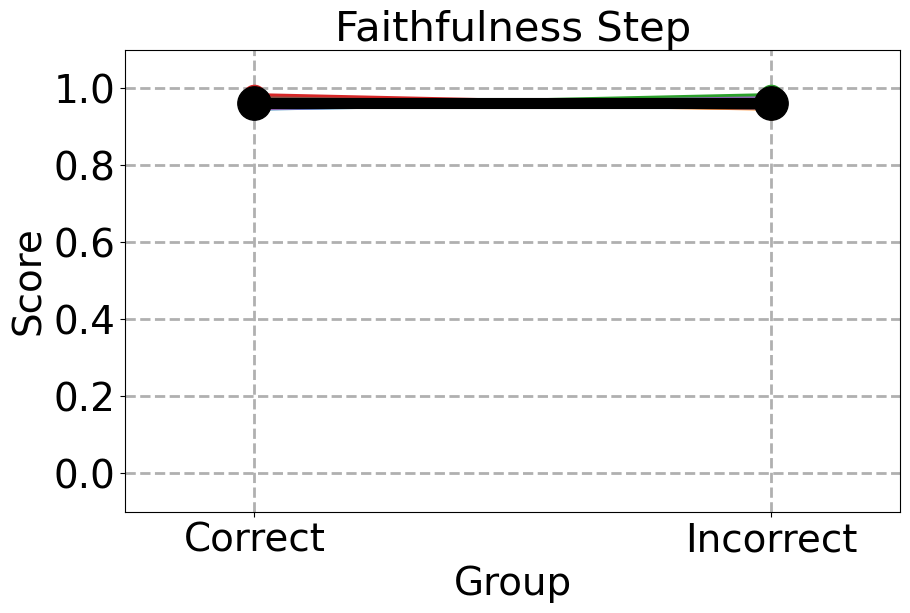


Group Means:
label
Correct      0.961311
Incorrect    0.961311
dtype: float64

Group STDs:
label
Correct      0.012171
Incorrect    0.012171
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Informativeness Step
s_step


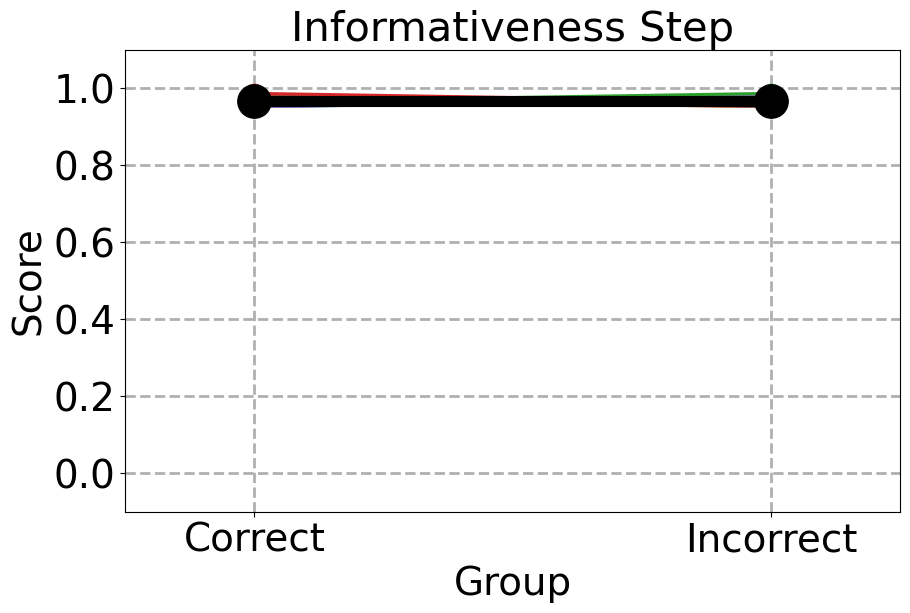


Group Means:
label
Correct      0.966882
Incorrect    0.966882
dtype: float64

Group STDs:
label
Correct      0.01005
Incorrect    0.01005
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

 >>>>>> Evaluate Semantic Similarity <<<<<<

##################################################

>>> Metric: Info Chain
_chain


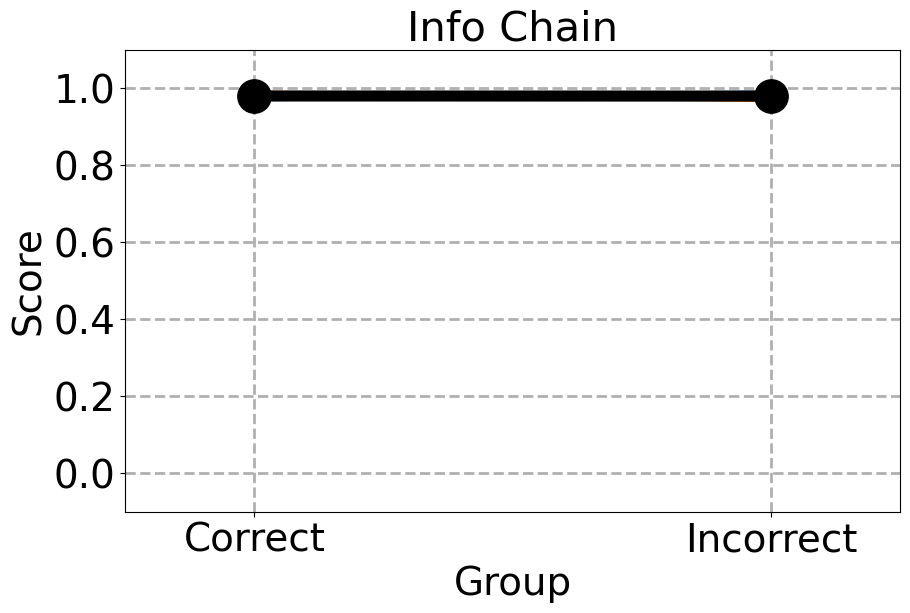


Group Means:
label
Correct      0.979886
Incorrect    0.979614
dtype: float64

Group STDs:
label
Correct      0.005236
Incorrect    0.005571
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.10056980888506657
 P-value: 0.9213234247718194

Mann-Whitney U Test:
 Test Statistic: 34.0
 P-value: 0.8784770784770783

Wilcoxon Signed Rank test:
 Test Statistic: 16.0
 P-value: 0.84375
> NO statistically significant difference

##################################################

>>> Metric: Repetition Step
n_step


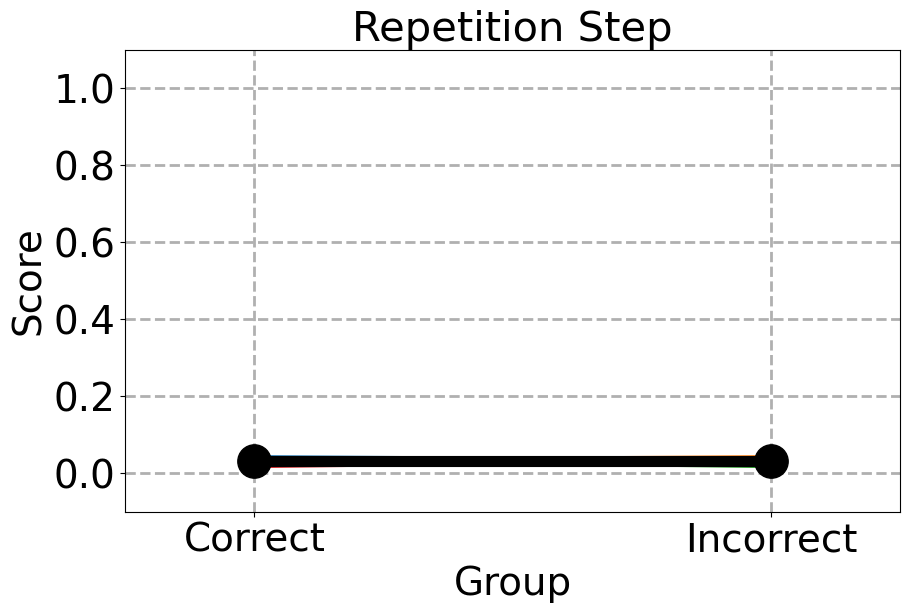


Group Means:
label
Correct      0.031221
Incorrect    0.031221
dtype: float64

Group STDs:
label
Correct      0.007034
Incorrect    0.007034
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

 >>>>>> Evaluate Logical Inference <<<<<<

##################################################

>>> Metric: Self Consistency (min)
 (min)


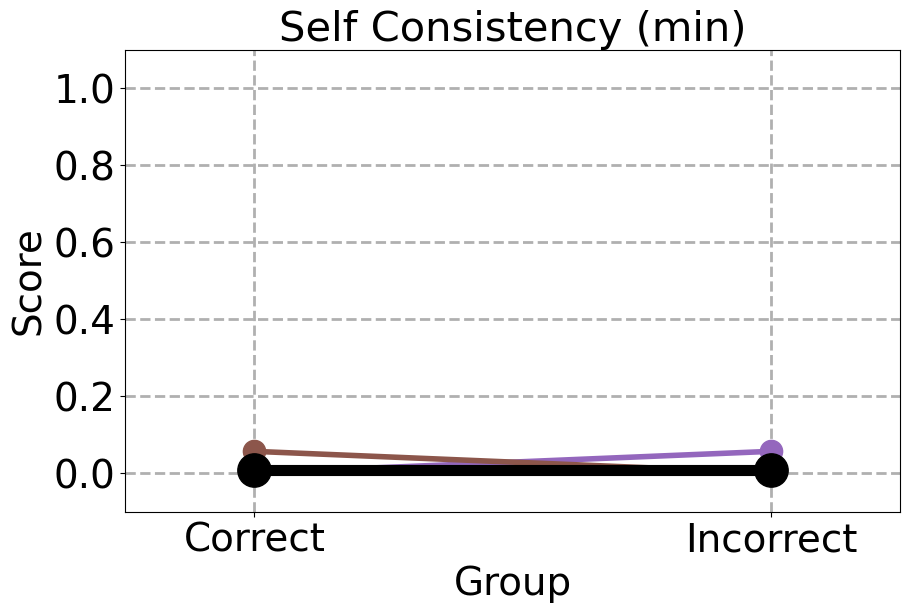


Group Means:
label
Correct      0.008569
Incorrect    0.008569
dtype: float64

Group STDs:
label
Correct      0.019542
Incorrect    0.019542
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Source Consistency (min)
 (min)


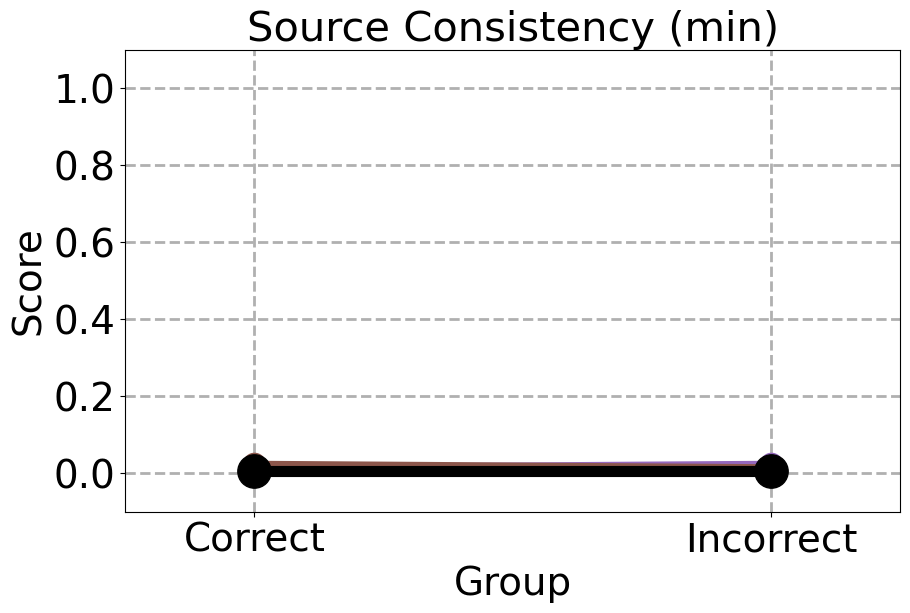


Group Means:
label
Correct      0.005874
Incorrect    0.005874
dtype: float64

Group STDs:
label
Correct      0.009478
Incorrect    0.009478
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Self Consistency (mean)
(mean)


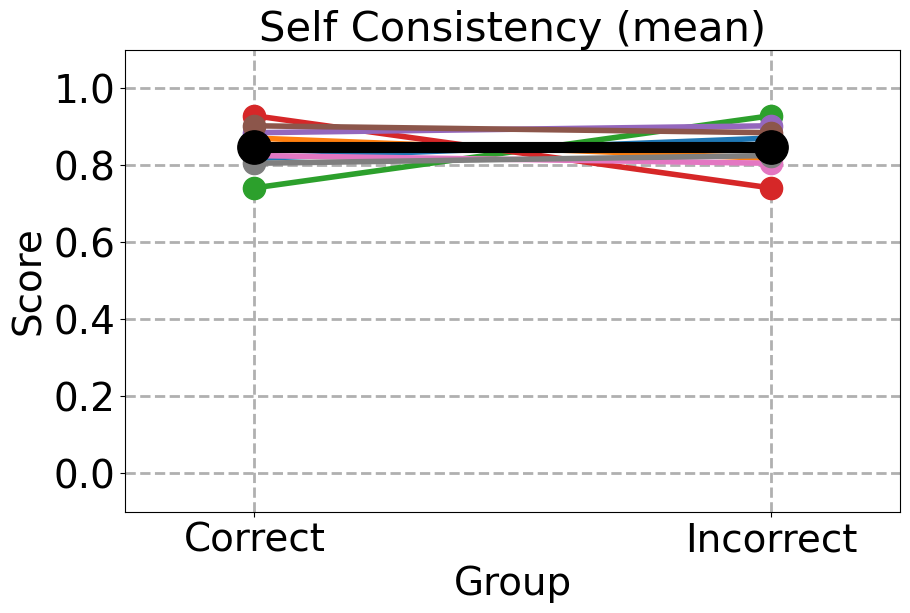


Group Means:
label
Correct      0.846865
Incorrect    0.846865
dtype: float64

Group STDs:
label
Correct      0.060973
Incorrect    0.060973
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Source Consistency (mean)
(mean)


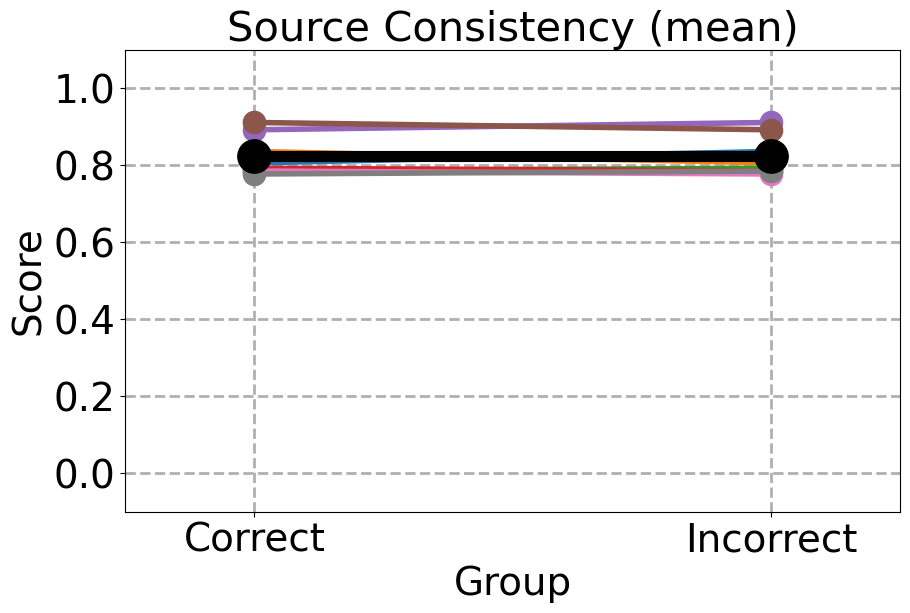


Group Means:
label
Correct      0.823066
Incorrect    0.823066
dtype: float64

Group STDs:
label
Correct      0.05195
Incorrect    0.05195
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

 >>>>>> Evaluate Language Coherence <<<<<<

##################################################

>>> Metric: Perplexity Chain
_chain


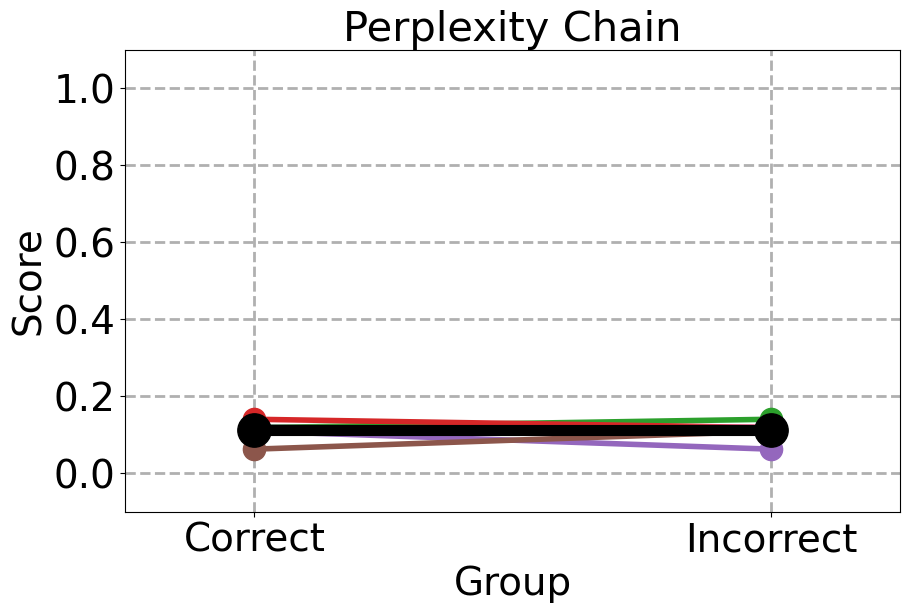


Group Means:
label
Correct      0.110995
Incorrect    0.110995
dtype: float64

Group STDs:
label
Correct      0.022101
Incorrect    0.022101
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Perplexity Step
y_step


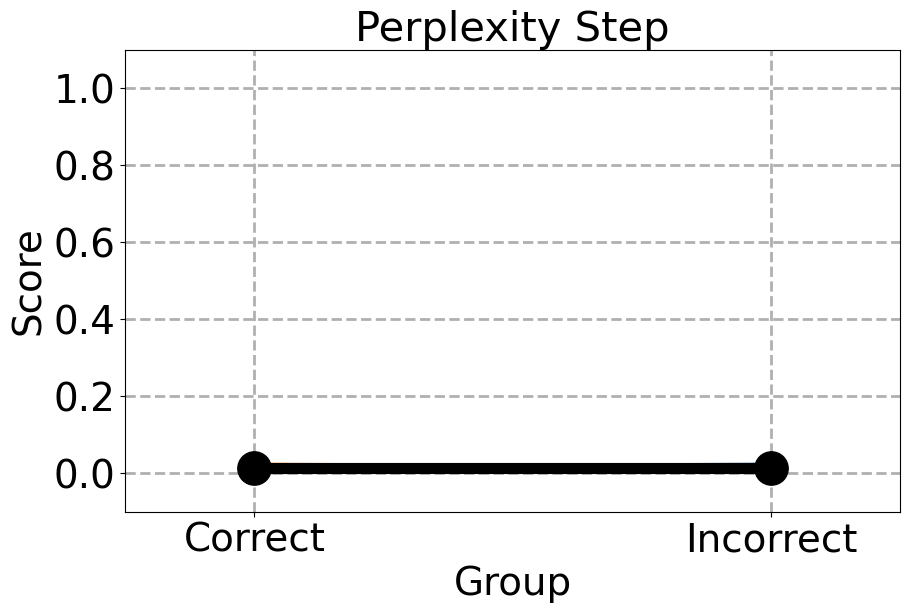


Group Means:
label
Correct      0.013654
Incorrect    0.013654
dtype: float64

Group STDs:
label
Correct      0.005089
Incorrect    0.005089
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference


In [8]:
# Load results
dict_KP_corr = json.load(open("KP/correct/evaluation_roscoe/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_roscoe/knowledge_perception.json"))

task_list = [
    'semantic_alignment',
    'semantic_similarity',
    'logical_inference',
    'language_coherence',
]

ignore = ['label', 'id']

for i, task in enumerate(task_list):
    print("\n" +"#" * 50)
    print(f"\n >>>>>> Evaluate {format_string(task)} <<<<<<")

    # Convert dicts to pandas dataframes
    df_corr = create_df_from_result(dict_KP_corr, label=0, task=task)
    df_incorr = create_df_from_result(dict_KP_incorr, label=0, task=task)

    # Set labels
    df_corr["label"] = "Correct"
    df_incorr["label"] = "Incorrect"

    # Concatenate dataframes
    df = pd.concat([df_corr, df_incorr], ignore_index=True)

    metrics = [c for c in df.columns.to_list() if c not in ignore]
    
    test_scores(df, metrics, type="KP")

## ReCEval

['intra-correctness (min) (k=0)', 'intra-correctness (mean) (k=0)', 'intra-correctness (min) (k=4)', 'intra-correctness (mean) (k=4)', 'intra-correctness (min) (k=8)', 'intra-correctness (mean) (k=8)', 'inter-correctness (min)', 'inter-correctness (mean)']

 >>>>>> Evaluate RCU Metrics <<<<<<

##################################################

>>> Metric: Intra Correctness (min) (k=0)
 (k=0)


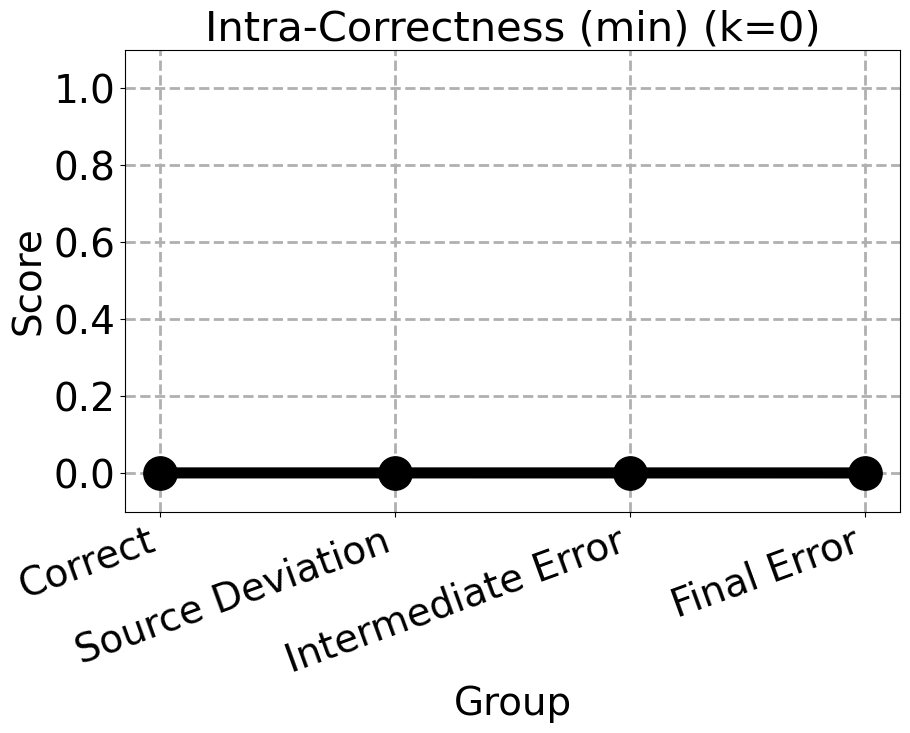


Group Means:
label
Correct               0.000320
Source Deviation      0.000320
Intermediate Error    0.000284
Final Error           0.000240
dtype: float64

Group STDs:
label
Correct               0.000256
Source Deviation      0.000256
Intermediate Error    0.000217
Final Error           0.000189
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.002524998347066623
 P-value: 0.9980209719130912

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.9250518935055844
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.3099208581908954
 P-value: 0.7613026548339048

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.95799832386793

Wilcoxon Signed Rank test:
 Test Statistic: 5.0
 P-value: 0.22514631086465808
>

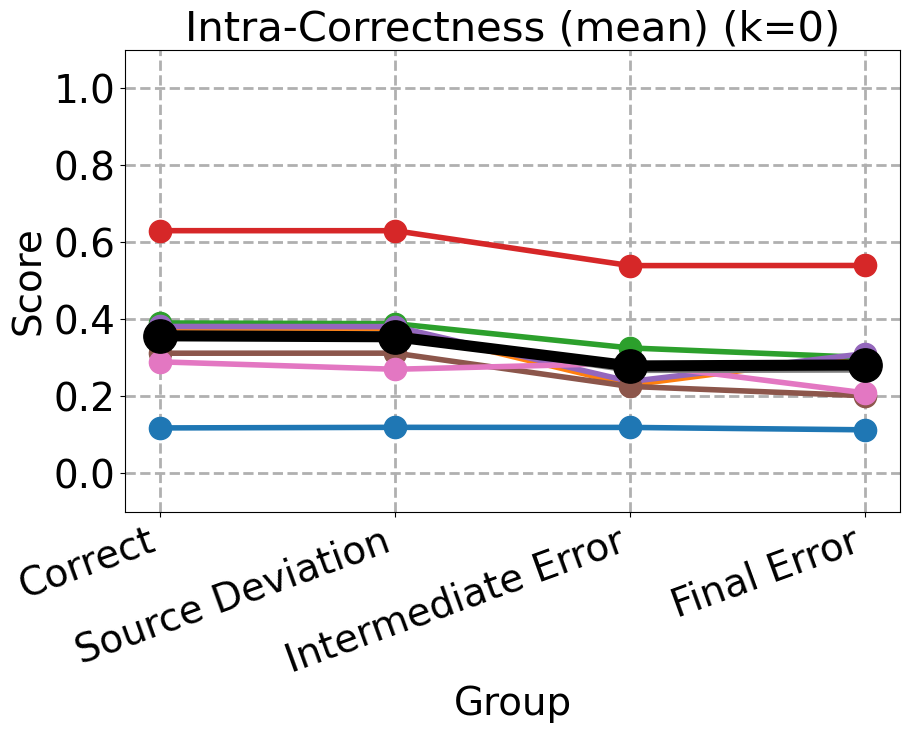


Group Means:
label
Correct               0.356427
Source Deviation      0.353902
Intermediate Error    0.278152
Final Error           0.280714
dtype: float64

Group STDs:
label
Correct               0.141686
Source Deviation      0.142696
Intermediate Error    0.121111
Final Error           0.124746
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.03551892499722754
 P-value: 0.9721674529538045

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 11.0
 P-value: 0.3828125
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.1877850194483828
 P-value: 0.2551484329638772

Mann-Whitney U Test:
 Test Statistic: 48.0
 P-value: 0.10489510489510488

Wilcoxon Signed Rank test:
 Test Statistic: 1.0
 P-value: 0.015625
> St

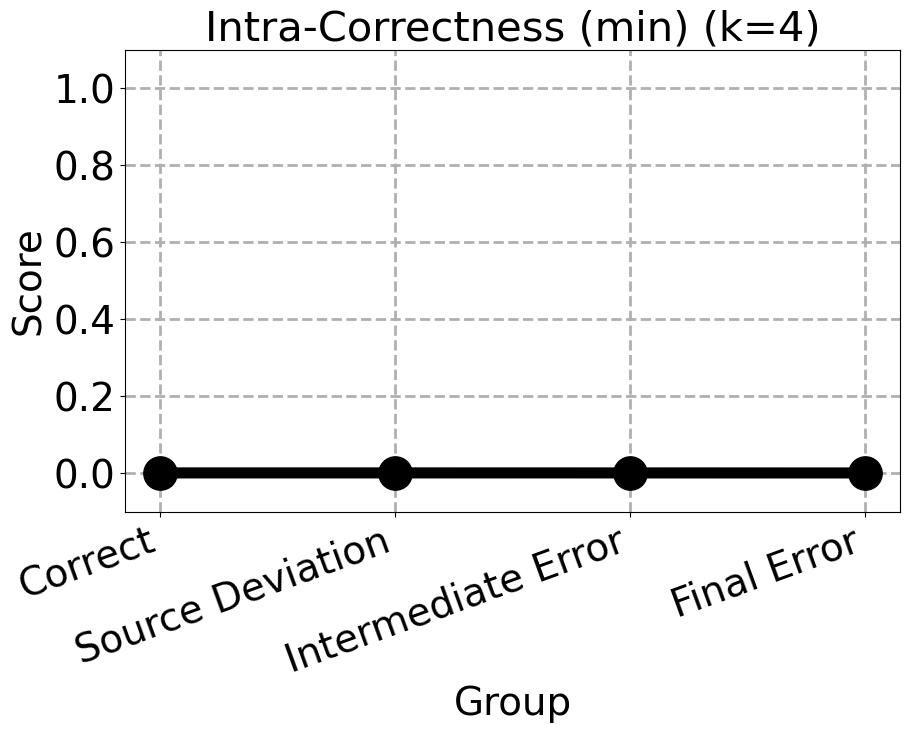


Group Means:
label
Correct               0.000317
Source Deviation      0.000317
Intermediate Error    0.000276
Final Error           0.000192
dtype: float64

Group STDs:
label
Correct               0.000251
Source Deviation      0.000251
Intermediate Error    0.000229
Final Error           0.000065
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
All paired differences are zero; Wilcoxon test cannot be applied!

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.34300730536913415
 P-value: 0.736731221695851

Mann-Whitney U Test:
 Test Statistic: 34.5
 P-value: 0.8332720830457769

Wilcoxon Signed Rank test:
 Test Statistic: 10.0
 P-value: 0.468159909854428
> NO statistically significant difference

---------------

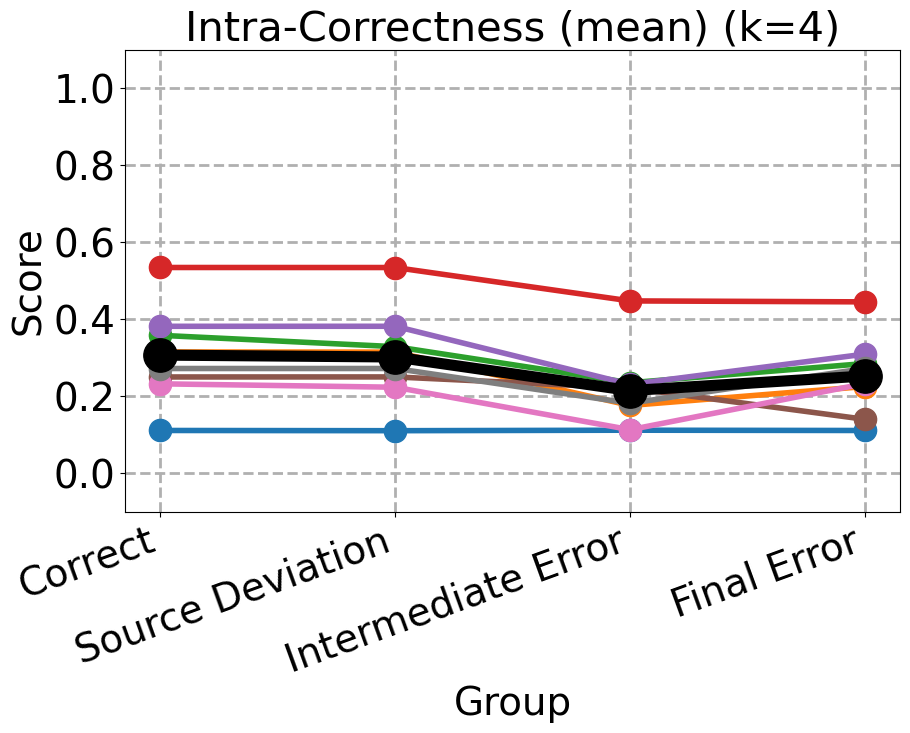


Group Means:
label
Correct               0.306298
Source Deviation      0.301384
Intermediate Error    0.214150
Final Error           0.252044
dtype: float64

Group STDs:
label
Correct               0.124447
Source Deviation      0.123999
Intermediate Error    0.105867
Final Error           0.103904
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.07912121827343009
 P-value: 0.9380560333597945

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.1484375
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.5952115876234358
 P-value: 0.13355063066589504

Mann-Whitney U Test:
 Test Statistic: 49.0
 P-value: 0.08298368298368297

Wilcoxon Signed Rank test:
 Test Statistic: 1.0
 P-value: 0.015625
> St

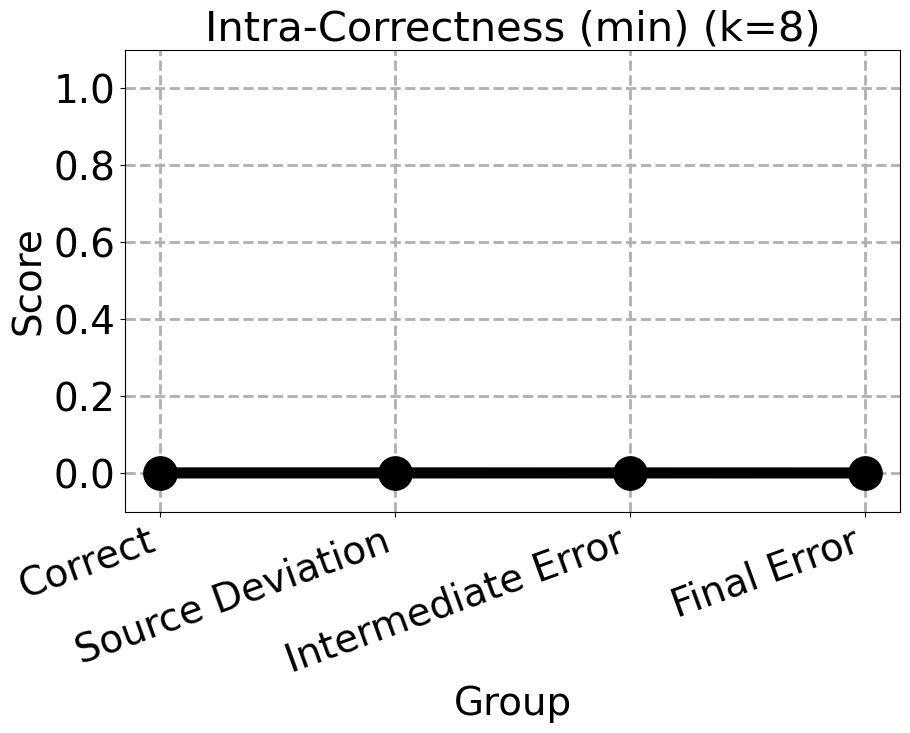


Group Means:
label
Correct               0.000311
Source Deviation      0.000311
Intermediate Error    0.000265
Final Error           0.000206
dtype: float64

Group STDs:
label
Correct               0.000263
Source Deviation      0.000263
Intermediate Error    0.000224
Final Error           0.000134
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.0010324446056874494
 P-value: 0.9991907959810649

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 7.0
 P-value: 0.9250518935055844
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 0.3752217179680396
 P-value: 0.7132595484543833

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.95799832386793

Wilcoxon Signed Rank test:
 Test Statistic: 5.0
 P-value: 0.22514631086465808


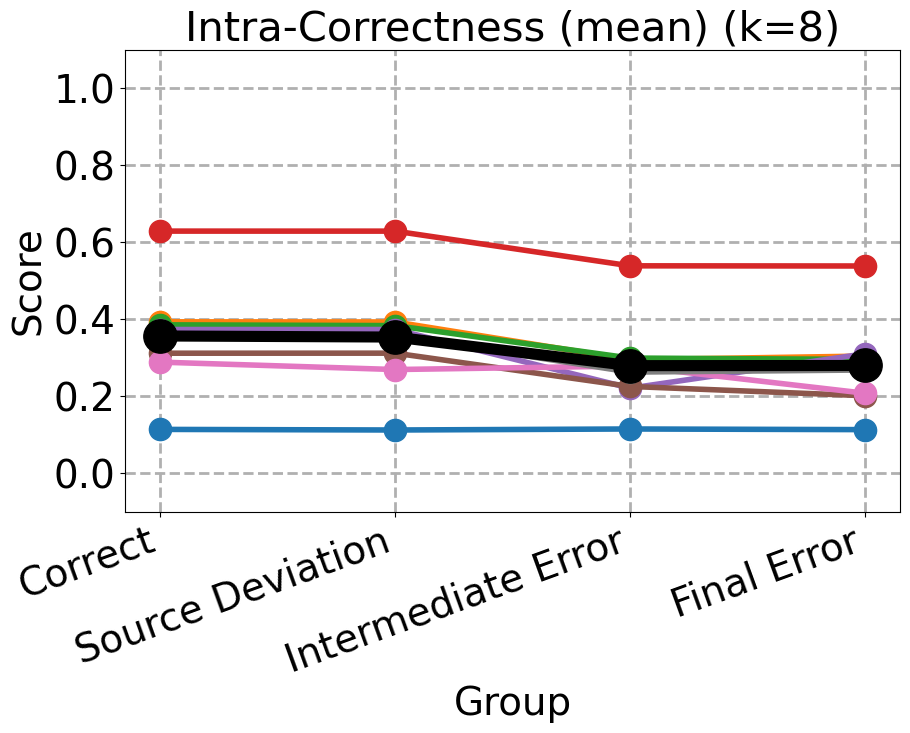


Group Means:
label
Correct               0.356002
Source Deviation      0.353150
Intermediate Error    0.278883
Final Error           0.279336
dtype: float64

Group STDs:
label
Correct               0.142517
Source Deviation      0.144249
Intermediate Error    0.120437
Final Error           0.124101
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.03978271632759651
 P-value: 0.9688281958609899

Mann-Whitney U Test:
 Test Statistic: 33.0
 P-value: 0.959129759129759

Wilcoxon Signed Rank test:
 Test Statistic: 8.0
 P-value: 0.1953125
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.1690061615918312
 P-value: 0.2624527662419698

Mann-Whitney U Test:
 Test Statistic: 48.0
 P-value: 0.10489510489510488

Wilcoxon Signed Rank test:
 Test Statistic: 1.0
 P-value: 0.015625
> Sta

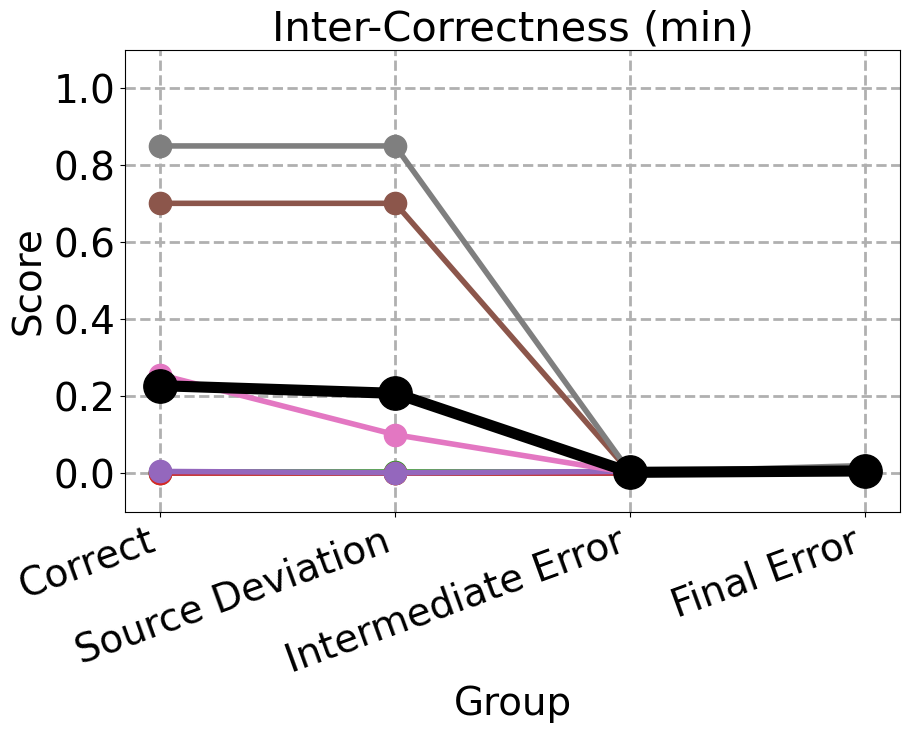


Group Means:
label
Correct               0.226875
Source Deviation      0.207015
Intermediate Error    0.001799
Final Error           0.005394
dtype: float64

Group STDs:
label
Correct               0.351696
Source Deviation      0.354483
Intermediate Error    0.001112
Final Error           0.006153
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.1124952451483391
 P-value: 0.912027942669417

Mann-Whitney U Test:
 Test Statistic: 37.0
 P-value: 0.635005519945619

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.15822064245182277
> NO statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 1.8101075774773976
 P-value: 0.11319613575848556

Mann-Whitney U Test:
 Test Statistic: 42.0
 P-value: 0.3169975086812533

Wilcoxon Signed Rank test:
 Test Statistic: 5.0
 P-value: 0.2251

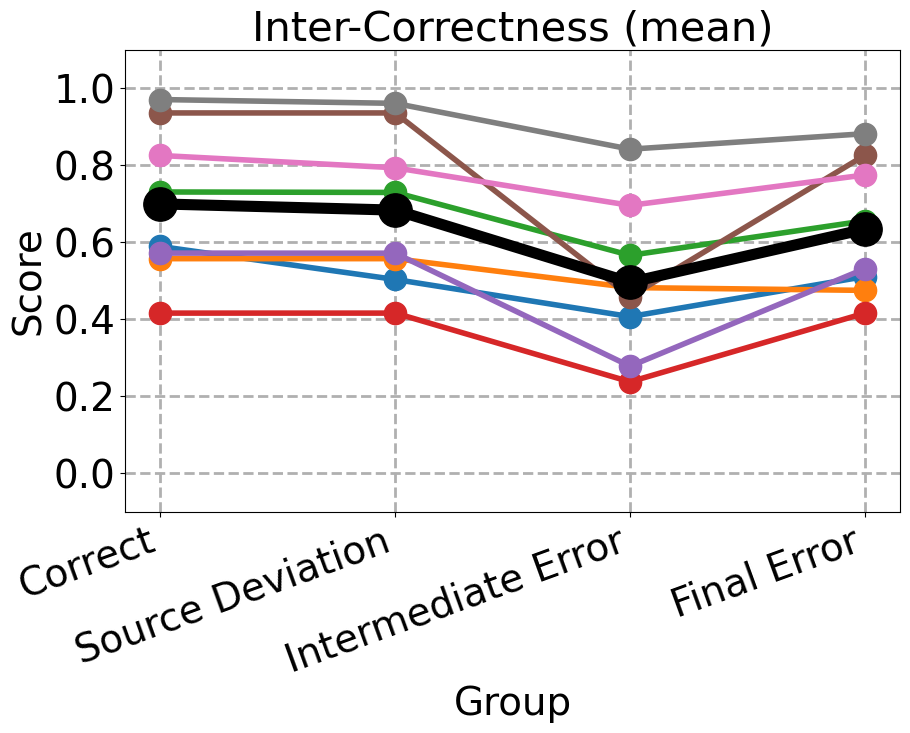


Group Means:
label
Correct               0.699008
Source Deviation      0.682876
Intermediate Error    0.495331
Final Error           0.633372
dtype: float64

Group STDs:
label
Correct               0.198324
Source Deviation      0.202571
Intermediate Error    0.202916
Final Error           0.176148
dtype: float64

--------------------------------------------------
> Comparing Correct vs Source Deviation:

Welch's t-test:
 Test Statistic: 0.16095104089604825
 P-value: 0.874432449836497

Mann-Whitney U Test:
 Test Statistic: 36.5
 P-value: 0.6737450351078312

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.029523215949937873
> Statistically significant difference

--------------------------------------------------
> Comparing Correct vs Intermediate Error:

Welch's t-test:
 Test Statistic: 2.030344581729479
 P-value: 0.061776905184661106

Mann-Whitney U Test:
 Test Statistic: 50.0
 P-value: 0.06495726495726495

Wilcoxon Signed Rank test:
 Test Statistic: 0.0
 P-value: 0.007

In [9]:
# Load results
dict_IE_corr = json.load(open("IE/correct/evaluation_receval/infer_emotion.json"))
dict_IE_source_dev = json.load(open("IE/source_dev/evaluation_receval/infer_emotion.json"))
dict_IE_wrong_inter = json.load(open("IE/inter_err/evaluation_receval/infer_emotion.json"))
dict_IE_wrong_final = json.load(open("IE/final_err/evaluation_receval/infer_emotion.json"))

ignore = ['label', 'id']

# Convert dicts to pandas dataframes
df_corr = create_df_from_result(dict_IE_corr, label=0, task="rcu")
df_source_dev = create_df_from_result(dict_IE_source_dev, label=0, task="rcu")
df_wrong_inter = create_df_from_result(dict_IE_wrong_inter, label=0, task="rcu")
df_wrong_final = create_df_from_result(dict_IE_wrong_final, label=0, task="rcu")

# Set labels
df_corr["label"] = "Correct"
df_source_dev["label"] = "Source Deviation"
df_wrong_inter["label"] = "Intermediate Error"
df_wrong_final["label"] = "Final Error"

# Concatenate dataframes
df = pd.concat([df_corr, df_source_dev, df_wrong_inter, df_wrong_final], ignore_index=True)

metrics = [c for c in df.columns.to_list() if c not in ignore]
print(metrics)

print(f"\n >>>>>> Evaluate RCU Metrics <<<<<<")
test_scores(df, metrics)

['label', 'id', 'intra-correctness (min) (k=0)', 'intra-correctness (mean) (k=0)', 'intra-correctness (min) (k=4)', 'intra-correctness (mean) (k=4)', 'intra-correctness (min) (k=8)', 'intra-correctness (mean) (k=8)', 'inter-correctness (min)', 'inter-correctness (mean)']

 >>>>>> Evaluate RCU Metrics <<<<<<

##################################################

>>> Metric: Intra Correctness (min) (k=0)
 (k=0)


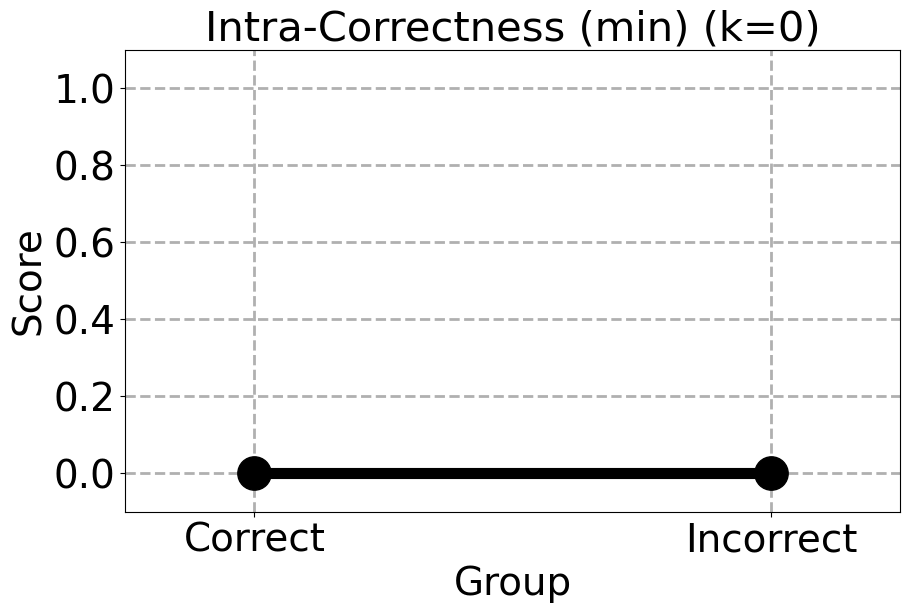


Group Means:
label
Correct      0.000311
Incorrect    0.000311
dtype: float64

Group STDs:
label
Correct      0.000142
Incorrect    0.000142
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Intra Correctness (mean) (k=0)
 (k=0)


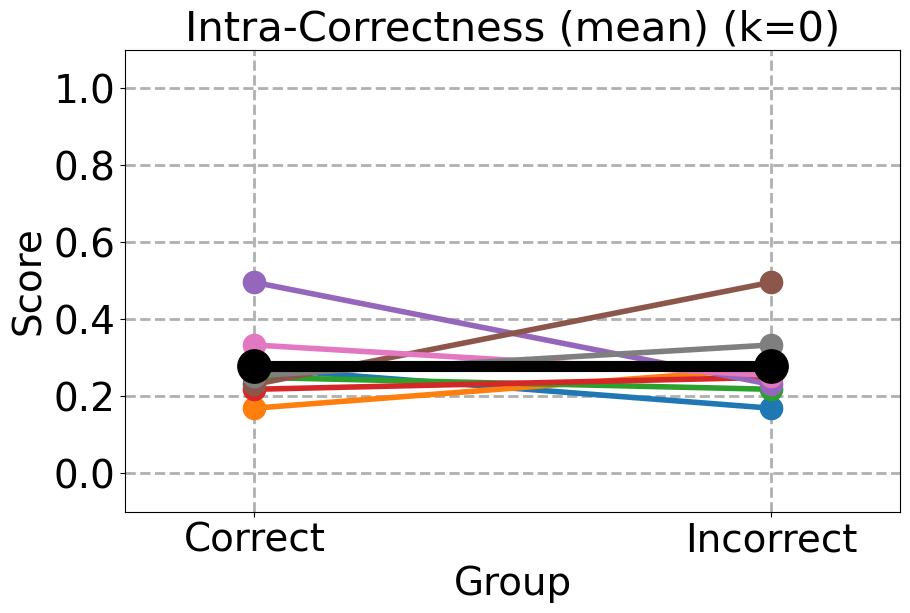


Group Means:
label
Correct      0.27775
Incorrect    0.27775
dtype: float64

Group STDs:
label
Correct      0.099799
Incorrect    0.099799
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Intra Correctness (min) (k=4)
 (k=4)


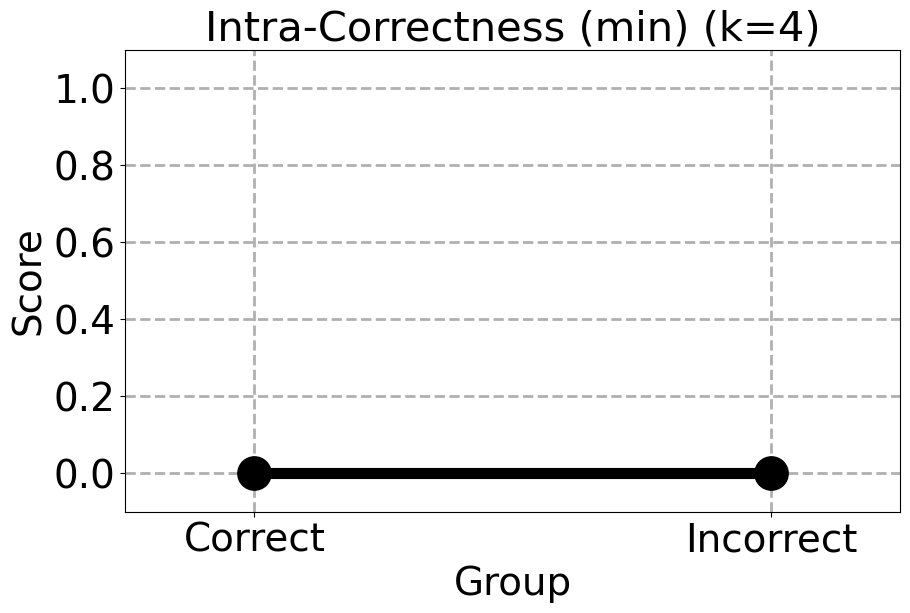


Group Means:
label
Correct      0.000269
Incorrect    0.000269
dtype: float64

Group STDs:
label
Correct      0.000168
Incorrect    0.000168
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Intra Correctness (mean) (k=4)
 (k=4)


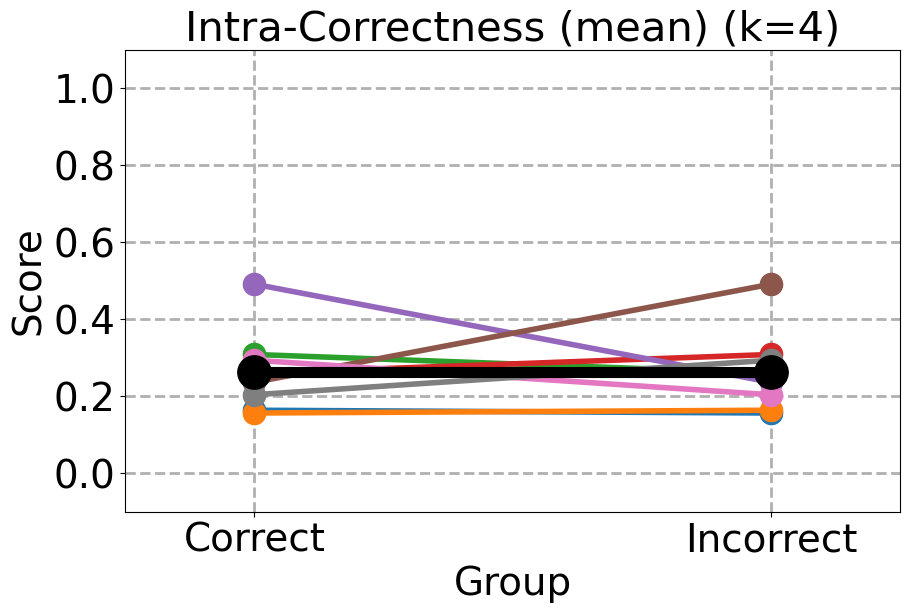


Group Means:
label
Correct      0.264082
Incorrect    0.264082
dtype: float64

Group STDs:
label
Correct      0.107218
Incorrect    0.107218
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Intra Correctness (min) (k=8)
 (k=8)


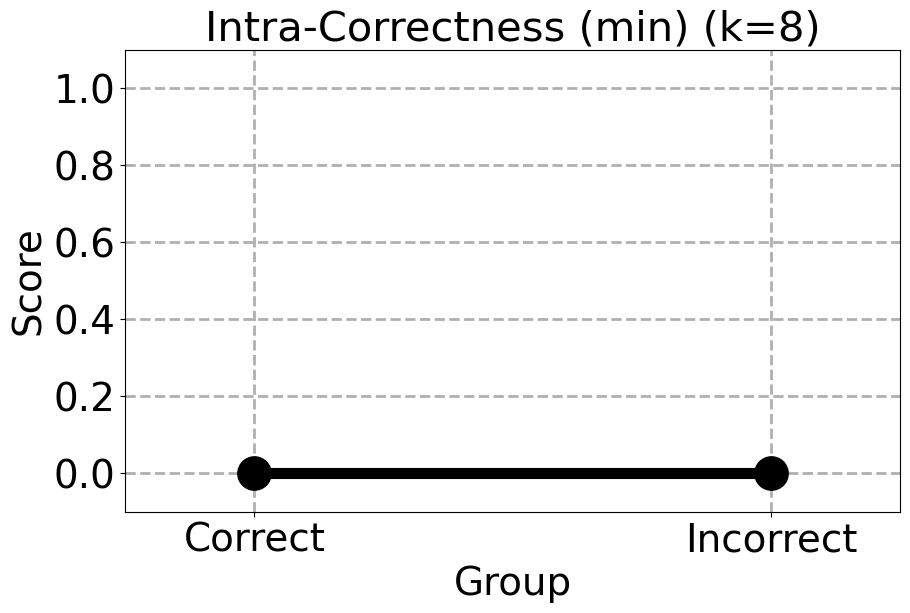


Group Means:
label
Correct      0.000317
Incorrect    0.000317
dtype: float64

Group STDs:
label
Correct      0.000139
Incorrect    0.000139
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Intra Correctness (mean) (k=8)
 (k=8)


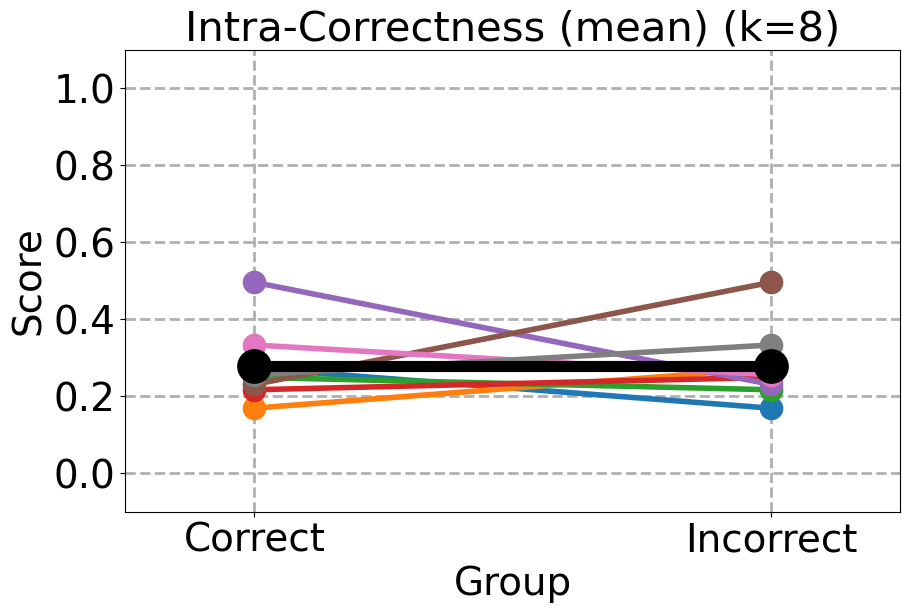


Group Means:
label
Correct      0.277845
Incorrect    0.277845
dtype: float64

Group STDs:
label
Correct      0.099839
Incorrect    0.099839
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Inter Correctness (min)
 (min)


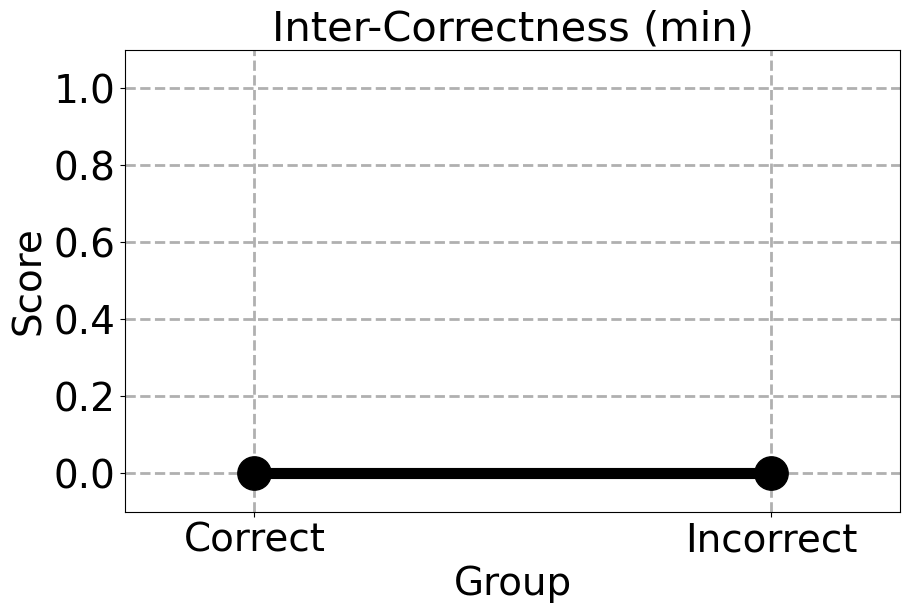


Group Means:
label
Correct      0.000956
Incorrect    0.000956
dtype: float64

Group STDs:
label
Correct      0.000814
Incorrect    0.000814
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference

##################################################

>>> Metric: Inter Correctness (mean)
(mean)


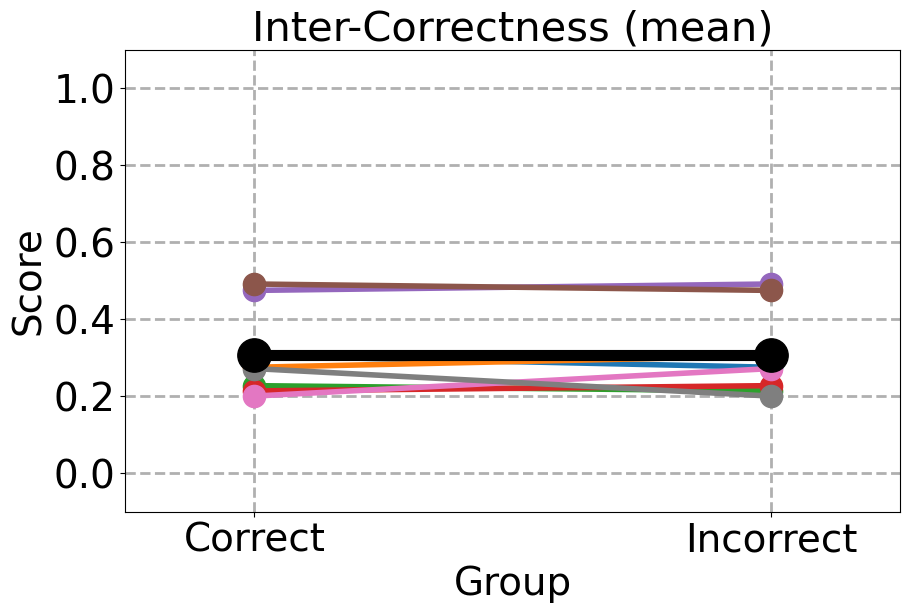


Group Means:
label
Correct      0.307451
Incorrect    0.307451
dtype: float64

Group STDs:
label
Correct      0.113943
Incorrect    0.113943
dtype: float64

--------------------------------------------------
> Comparing Correct vs Incorrect:

Welch's t-test:
 Test Statistic: 0.0
 P-value: 1.0

Mann-Whitney U Test:
 Test Statistic: 32.0
 P-value: 1.0

Wilcoxon Signed Rank test:
 Test Statistic: 18.0
 P-value: 1.0
> NO statistically significant difference


In [10]:
# Load results
dict_KP_corr = json.load(open("KP/correct/evaluation_receval/knowledge_perception.json"))
dict_KP_incorr = json.load(open("KP/incorrect/evaluation_receval/knowledge_perception.json"))

ignore = ['label', 'id']
print(df.columns.to_list())

# Convert dicts to pandas dataframes
df_corr = create_df_from_result(dict_KP_corr, label=0, task="rcu")
df_incorr = create_df_from_result(dict_KP_incorr, label=0, task="rcu")

# Set labels
df_corr["label"] = "Correct"
df_incorr["label"] = "Incorrect"

# Concatenate dataframes
df = pd.concat([df_corr, df_incorr], ignore_index=True)

metrics = [c for c in df.columns.to_list() if c not in ignore]

print(f"\n >>>>>> Evaluate RCU Metrics <<<<<<")
test_scores(df, metrics, type="KP")